# Visualizing the drift rate and location of a detected signal of interest
********
**Author** - Anna Gagnebin (Sacramento State Physics, 2023)

**Mentor** - Dr. David DeBoer

Summer 2021 - Berkeley SETI Research Center
********

##### Background and goal of the notebook:

This Notebook was developed to help a user visually analyze the drift of a potential signal of interest to verify whether it: 
1. may be extraterrestrial in origin
2. could have originated from a source located in the direction it was observed

In order to do this, we will attempt to determine whether the drift of the signal agrees with the drift of the Earth's motion with the assumption that the signal was sent intentionally from a stationary extraterrestrial source (or that the drift of the source has already been corrected for). The notebook will also help to visualise how the location of both the observer and the source would affect the drift rate of the signal.

##### What makes a signal interesting?

There are two things that would mark a signal as interesting:
1. It is observed only when the telescope is pointed at a specific point on the sky, but is not present when the telescope is pointing far enough away from the source that the signal should no longer be observed.
  - SETI generally uses an on-off search cadence where the telescope spends time pointing at a specific star and then moves to another point on the sky and spends an equal amount of time in this direction to help determine whether the signal is directional or not. Occasionally, the telescope is being used for other astronomical purposes, so the on-off cadence uses unequal on-off observation periods, but the idea is still the same.
  - If the signal is <i>only</i> observed in the on portion of observation, then the potential signal source would lie in the direction in which the telescope was pointed at that time.
  
  
2. The drift doesn’t seem to match that of any known astrophysical phenomenon or radio interference at the central frequency of the signal.
 - There are some natural phenomena that may mimic the SETI on-off cadence (e.g. pulsars and fast radio bursts), so it is possible that these sources could pass the first criteria.
 - There are also specific radio frequencies that are allocated to radio stations or other forms of communication, and if a source transmitting or receiving a signal is in motion, it would also have a frequency drift.

###### The difference between frequency shift and frequency drift:

- <b>Frequency Shift</b> is the change of the frequency of a signal in time  (in $ Hz/s $) due to the relative movement of both the signal source and the Earth (essentially the same as the velocity of the frequency [or change of frequency in time]).
- <b>Frequency Drift</b> is the change of the velocity of the frequency of a signal in time (in $ Hz/s^2 $) due to the relative movement of the signal source and the Earth (essentially the same as the acceleration of the frequency [or change of velocity in time]).

###### Known causes of frequency drift:

If the signal is extraterrestrial in origin, its drift may be caused by the motion of our solar system barycenter, the motion of Earth's geocenter around the sun, the rotation of the Earth at the location of the observer, or the motion of the signal source. For the purpose of this notebook, we will only be focusing on the first three movements (the solar system barycenter, Earth's geocenter, and the location of the observer).

If the obseved signal is due to man-made radio interference, drift may be caused by the emission of radio waves from phones, radios, or other transmitters in or on moving cars, bicycles, planes, satellites, or probes. Radio telescopes tend to have radio silent zones around them, but if anyone were to forget to put their phone on airplane mode or turn off the radio while on a moving bicycle or in a moving car, this could cause a signal drift that may appear similar to the drift of an extraterrestrial signal. Additionally, transmissions to or from an airplane, probe, or man-made satellite would also exhibit a frequency drift due to their movement. The final source of potential man-made frequency drift is due to the electronic oscillations of Earth-bound transmitters.

##### How this code will help with the search for extraterrestrial intelligence
By the time a signal is deemed interesting, it has already passed the criteria for both the on-off search cadence as well as the uniqueness of the frequency drift. Following this, the next step is to analyze whether or not the drift of the signal could be caused by the motion of man-made radio sources as mentioned above. There has been code written by Dr. DeBoer to do this, and something to be done following this summer would be to update these files so they may be more easily used. If none of these seem to match the drift of the signal, another step is to determine whether or not the drift matches what we would see from an extraterrestrial signal originating at the location of the apparent signal source, which is what this Notebook was written to do.

### Choose a signal

Throughout the first part of this notebook, we will only be focusing on one signal. This could be the source of a signal of interest, or just a random star if your goal is to learn how drift rates work. If the star is one with a common name, you can input the name when prompted. Otherwise, you can type 'Custom' and input the right ascension and declination individually.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.units as u
import numpy as np
from numpy import diff
import horizons
from datetime import datetime

In [2]:
soi = input("Name of star to look at or Custom (for specific ra and dec): ")
ax = []
ax2 = []
if soi == 'Custom' or soi == 'custom':
    if len(ra_s) < 11 or len(dec_s) < 10:
            print("Please make sure you put right ascension and declination in right (run again)")
            #break
    else:
        ra = float(ra_s[0:3]) + float(ra_s[4:6])/60.0 + float(ra_s[7:-2])/3600.0
        if dec_s[0] == '-':
            dec = -1.0 * (float(dec_s[1:3]) + float(dec_s[4:6])/60.0 + float(dec_s[7:-2])/3600.0)
        elif dec_s2[0] == '+':
            dec = +1.0 * float(dec_s[1:3]) + float(dec_s[4:6])/60.0 + float(dec_s[7:-2])/3600.0
if soi != "Custom" and soi != "custom":
    s = SkyCoord.from_name(soi, frame = 'icrs')
    ra = s.ra.deg
    dec = s.dec.deg   
dis = input("Distance to star (in ly [look up]): ")

Name of star to look at or Custom (for specific ra and dec): proxima centauri
Distance to star (in ly [look up]): 4.246


The distance of the star from the Earth is used for plotting purposes. The length of the line between the Sun and the star in the plots below depends on how far away the star is.

Now, we want to transform the location of the star relative to the Earth into cartesian coordinates. This makes it easier to understand the plots, since they're in a more familiar coordinate system.

In [3]:
#Setting constants (converting both ly (lightyears) and au (astronomical units) to meters)
ly = 9.461e15 #m
au = 149597870700 * u.m

#Converting the distance from lightyears to au
d = (float(dis) * ly * u.m/au) * u.au

#Going from gcrs to cartesian coordinates
sig_x = d * np.cos(np.deg2rad(ra))*np.cos(np.deg2rad(dec))
sig_y = d * np.sin(np.deg2rad(ra))*np.cos(np.deg2rad(dec))
sig_z = d * np.sin(np.deg2rad(dec))

#### Set the time range of observation

If you're looking at a star from which a signal of interest seems to have originated, then the start and end date and time will be centered around when the signal was observed. Otherwise, you can choose any date or time. Note: if you want to look at only one full day, the plots work better if you end at 23:59:00 on the same date as the start time instead of ending at the beginning of the next day.

In [4]:
time_start = input("Input the start date and time (yyyy-mm-dd hh:mm:ss): ")
time_end = input("Input the end date and time (yyyy-mm-dd hh:mm:ss): ")
ts = datetime.strptime(time_start, '%Y-%m-%d %H:%M:%S')
te = datetime.strptime(time_end, '%Y-%m-%d %H:%M:%S')
dt = (te - ts)/1000
use_times = []
for i in range(1001):
    use_times.append(ts + (i * dt))
time = Time(use_times)

Input the start date and time (yyyy-mm-dd hh:mm:ss): 2019-04-29 13:00:00
Input the end date and time (yyyy-mm-dd hh:mm:ss): 2019-04-29 19:00:00


## Generate files

Our next step is to create some ephemeris files.

An ephemeris is a table that gives you the location of a celestial object at any point in a specific time range.

##### Connect to JPL Horizons

To create the ephemeris files needed, go to the <a href="https://ssd.jpl.nasa.gov/horizons.cgi">JPL Horizons website</a>. JPL Horizons is an interface maintained by the Jet Propulsion Laboratory (JPL) and the California Institute of Technology (CalTech) to provide the location of any solar system body at a given time.

Steps:
- set Ephemeris Type as observer
- set Target Body as what you want to look at in each file (here, this is either the solar system barycenter or the Earth)
- set Observer Location as where you want to look from (this can be either a body in general or a specific location on the Earth)
- set Time Span as the start and end date and time you want in the file (in the fomat of YYYY-MM-DD HH:MM:SS)
- leave Table Settings as 1, 9, 20, 23, 24 (1. Right ascension and declination as seen from the observer while only correcting for light time; 9. The apparent magnitude of the object; 20. Distance of the source from the observer and the rate of change of this distance; 23. The target object's solar elongation (angle between the Earth-Sun line and the target) [also, /L means that the target is leading the Sun and /T means that the target is trailing the Sun]; 24. Angle of the line from Sun to Target to Observer)
- set Display/Output as default

Files you'll need:
- looking at Solar System Barycenter (0) from the location from where the signal was observed for a whole year (for example, if the signal was observed in 2021, Start = 2021-01-01 00:00:00 & Stop = 2022-01-01 00:00:00) (Step = 4 hours)
- looking at Earth (399) from Solar System Barycenter (500@0) for the whole year (Step = 4 hours)
- looking at Earth (399) from Solar System Barycenter (500@0) for the date the signal was observed (for example, if the signal was observed on January 1st, 2021, Start = 2021-01-01 00:00:00 & Stop = 2021-01-02 00:00:00) (Step = 15 minutes)
- looking at Solar System Barycenter (0) from Earth (500) for the date the signal was observed (Step = 15 minutes)


After generating each file:
- copy the ephemeris starting from the row of ** above Ephemeris/WWW_USER to the row of ** below $$EOE
- paste into a newly created .dat file for each ephemeris

For more information on the table settings, go to <a href = "https://ssd.jpl.nasa.gov/?horizons_doc#specific_quantities">the documentation</a>.

Below, we'll be using the horizons.py file to get the data from the four .dat files described above. Horizons.py reads in the files and calculates the cartesian coordinates and their velocities as well as giving the times of the ephemeris as a Time object, the right ascension in units of hour angle, the declination in units of degrees, the distance in units of au, the change in distance in units of m/s, and the change in velocity in units of $ m/s^2 $.

In [5]:
obs1_file = input("File name (including .dat) for looking at SSB from telescope: ")
gc_file = input("File name (including .dat) looking at Earth from SSB for full year: ")
gc_date_file = input("File name (including .dat) looking at Earth from SSB for date: ")
bary_file = input("File name (including .dat) looking at SSB from Earth for date: ")
obs1 = horizons.Horizons(obs1_file)
gc = horizons.Horizons(gc_file)
gcd = horizons.Horizons(gc_date_file)
bary = horizons.Horizons(bary_file)

File name (including .dat) for looking at SSB from telescope: pks_ssb.dat
File name (including .dat) looking at Earth from SSB for full year: earth_gc.dat
File name (including .dat) looking at Earth from SSB for date: earth_gc3.dat
File name (including .dat) looking at SSB from Earth for date: barycenter.dat
Target body name: Solar System Barycenter (0)     {source: DE441}
Observers location: Parkes Radio Telescope 64-m
Start time      : A.D. 2019-Jan-01 00:00:00.0000 UT
Stop  time      : A.D. 2020-Jan-01 00:00:00.0000 UT
Step-size       : 240 minutes
Target body name: Earth (399)                     {source: DE441}
Observers location: BODYCENTRIC
Start time      : A.D. 2019-Jan-01 00:00:00.0000 UT
Stop  time      : A.D. 2020-Jan-01 00:00:00.0000 UT
Step-size       : 240 minutes
Target body name: Earth (399)                     {source: DE441}
Observers location: BODYCENTRIC
Start time      : A.D. 2019-Apr-29 00:00:00.0000 UT
Stop  time      : A.D. 2019-Apr-30 00:00:00.0000 UT
Step-siz

## Set the location of observation

Now we'll need to determine the location of observation on the Earth, as well as the location of the star relative to the observer.

To see what observatories are used by EarthLocation - which finds the geocentric (x, y, z) or geodetic (longitude, latitude, height) coordinates of the observer depending on the Earth's geocenter - run the code below. If your observatory is not included, you'll need to look up the longitude, latitude, and height and input them manually.

In [ ]:
EarthLocation.get_site_names()

First, get the geodetic location (based on the longitude, latitude, and height) of the observatory by using EarthLocation and either the name of the observatory or by manually inputting the latitude, longitude, and height of the observatory. Latitude is positive to the North and Longitude is positive to the East.

In [6]:
name = input("Input name of observatory: ")
if name in EarthLocation.get_site_names():
    obs_loc = EarthLocation.of_site(name)
else:
    print("That observatory is not in EarthLocation. Please input the location of the observatory manually!")
    lat = input("Latitude of the location of observation (in degrees): ")
    lon = input("Longitude of the location of observation (in degrees): ")
    height = input("Height of the location of observation (in meters): ")
    obs_loc = EarthLocation(lon = float(lon) * u.deg, lat = float(lat) * u.deg, height = float(height) * u.m)

Input name of observatory: Parkes
That observatory is not in EarthLocation. Please input the location of the observatory manually!
Latitude of the location of observation (in degrees): -32.995126867833136
Longitude of the location of observation (in degrees): 148.26238459073372
Height of the location of observation (in meters): 480.1


Next, calculate the azimuth and altitude of the source star from the observatory for the times you specified above. Azimuth and altitude are essentially right ascension and declination given relative to the observer's location. To do this, we will use SkyCoord to find get the right ascension and declination in the international celestial reference system and then convert it into the geocentric celestial reference system. After that, we'll use AltAz to convert right ascension and declination into azimuth and altitude.

In [7]:
altaz = []
obs_az = []
obs_el = []

ptg = SkyCoord(ra=np.deg2rad(ra) * u.rad, dec=np.deg2rad(dec) * u.rad, frame='icrs')
for i in range(len(time)):
    altaz.append(ptg.gcrs.transform_to(AltAz(obstime = time.value[i], location = obs_loc)))
    obs_az.append(altaz[i].az.value)
    obs_el.append(altaz[i].alt.value)

Now, we'll need to calculate the distance (in m), velocity (in m/s), and acceleration (in m/s^2) of the source relative to the observer in geocentric coordinates:

In [8]:
sec = []
for i in range(len(time)):
    sec.append((time.value[i] - time.value[0]).seconds + (time.value[i] - time.value[0]).microseconds/1e6)

In [9]:
obs_gcrs_r, obs_gcrs_v = obs_loc.get_gcrs_posvel(time)
obs_gcrs_D = ((sig_x/d) * obs_gcrs_r.x + (sig_y/d) * obs_gcrs_r.y + (sig_z/d) * obs_gcrs_r.z)
obs_gcrs_Ddot = ((sig_x/d) * obs_gcrs_v.x + (sig_y/d) * obs_gcrs_v.y + (sig_z/d) * obs_gcrs_v.z)
obs_gcrs_Ddotdot = diff(obs_gcrs_Ddot) / diff(sec * u.s)

as well as barycentric coordinates:

In [10]:
bary.at(time)
obs_icrs_v_x = bary.xdot + obs_gcrs_v.x
obs_icrs_v_y = bary.ydot + obs_gcrs_v.y
obs_icrs_v_z = bary.zdot + obs_gcrs_v.z
obs_icrs_Ddot = ((sig_x/d) * obs_icrs_v_x + (sig_y/d) * obs_icrs_v_y + (sig_z/d) * obs_icrs_v_z)
obs_icrs_Ddotdot = diff(obs_icrs_Ddot) / diff(sec * u.s)

## Code to make waterfall plots

This code will be used later to simulate what the waterfall plots of incoming signals may look like. It can be used to plot one or two signals. If only plotting one signal, input a placeholder of an array of 0 (ddot0) in either Ddot1 or Ddot2. 

These waterfall plots show time in seconds vs Hz offset with the y axis (time) given with 0 at the top and the maximum at the bottom.

In a real signal, there will be noise that makes the signal slightly harder to see. For the purpose of this notebook, however, we will set noise to be a single value since the goal is to be able to clearly see the shape of the signal.

In [11]:
def waterfall(f, time, Tsys, flo, fhi, bw, minsmear, Ddot1, Ddot2, p, figname = 'waterfall', log = False):
    int_time = Time(time[1] - time[0], format = 'sec').value
    numch = int((fhi - flo)/bw)
    ch = np.linspace(flo, fhi, numch)
    s = np.sqrt(bw * int_time)
    tbin = (time - time[0]) / int_time
    pn = np.fabs(np.random.normal(p, p/s, numch))
    print("<Waterfall setup>")
    print(f"\tNch: {numch}, Ntimes: {len(time)}")
    print(f"\tflo: {flo:.2f} Hz, fhi: {fhi:.2f} Hz, int_time: {int_time:.1f} s")
    obs_wf1 = [[p] * len(pn)] * len(time)
    obs_wf2 = [[p/1e5] * len(pn)] * len(time)
    obs_wf1 = np.array(obs_wf1)
    obs_wf2 = np.array(obs_wf2)
    if np.array(Ddot1).max() == 0:
        fdop1 = np.array([0] * len(Ddot1))
    else:
        fdop1 = (Ddot1 / c0) * f
    if np.array(Ddot2).max() == 0:
        fdop2 = np.array([0] * len(Ddot2))
    else:
        fdop2 = (Ddot2 / c0) * f
    int_time = time[1] - time[0]
    key = 0
    print(f"<Adding {key}>")
    key += 1
    if len(fdop1) != len(time):
        print("Invalid number of spectra - skipping adding signal.")
        return
    obs_t = time
    obs_f1 = fdop1
    obs_f2 = fdop2
    chnum1 = (fdop1 - flo)/bw
    chnum2 = (fdop2 - flo)/bw
    tbin = (time - time[0]) / int_time
    for i in range(len(fdop1) - 1):
        this_time = int(tbin[i])
        if this_time > len(fdop1) - 2:
            this_time = len(fdop1) - 2
        this_chan1 = int(chnum1[i])
        smear1 = (fdop1[this_time+1] - fdop1[this_time])/bw
        if smear1 == 0.0:
            smear1 = minsmear
        elif abs(smear1) < minsmear:
            smear1 = minsmear * np.sign(smear1)
        if np.array(Ddot1).max() == 0:
            for k in range(this_chan1, this_chan1+int(minsmear), int(np.sign(minsmear))):
                obs_wf1[this_time, k] += 0
        else:
            for k in range(this_chan1, this_chan1+int(minsmear), int(np.sign(minsmear))):
                obs_wf1[this_time, k] += p/abs(minsmear)
    for i in range(len(fdop2) - 1):
        this_time = int(tbin[i])
        if this_time > len(fdop2) - 2:
            this_time = len(fdop2) - 2
        this_chan2 = int(chnum2[i])
        smear2 = (fdop2[this_time+1] - fdop2[this_time])/bw
        if smear2 == 0.0:
            smear2 = minsmear
        elif abs(smear2) < minsmear:
            smear2 = minsmear * np.sign(smear2)
        if np.array(Ddot2).max() == 0:
            for k in range(this_chan2, this_chan2+int(minsmear), int(np.sign(minsmear))):
                obs_wf2[this_time, k] += 0
        else:
            for k in range(this_chan2, this_chan2+int(minsmear), int(np.sign(minsmear))):
                obs_wf2[this_time, k] += p/abs(minsmear)
    import matplotlib.pyplot as plt
    plt.figure(figname)
    if log:
        show = np.log10(obs_wf1 + obs_wf2)
    else:
        show = obs_wf1 + obs_wf2
    plt.imshow(show, extent=[flo, fhi, Time(time[-1] - time[0], format = 'sec').value, 0], origin='upper')
    plt.xlabel('Channel offset (Hz)')
    plt.ylabel('Time (sec)')
    plt.axis('auto')

## Plot the visualization

What the plots show:
- the direction to the star on the different solstices and equinoxes
- the location of the star as it relates to the plane of the solar system
- what the incoming signal should look like with two different sets of assumptions

<IPython.core.display.Javascript object>


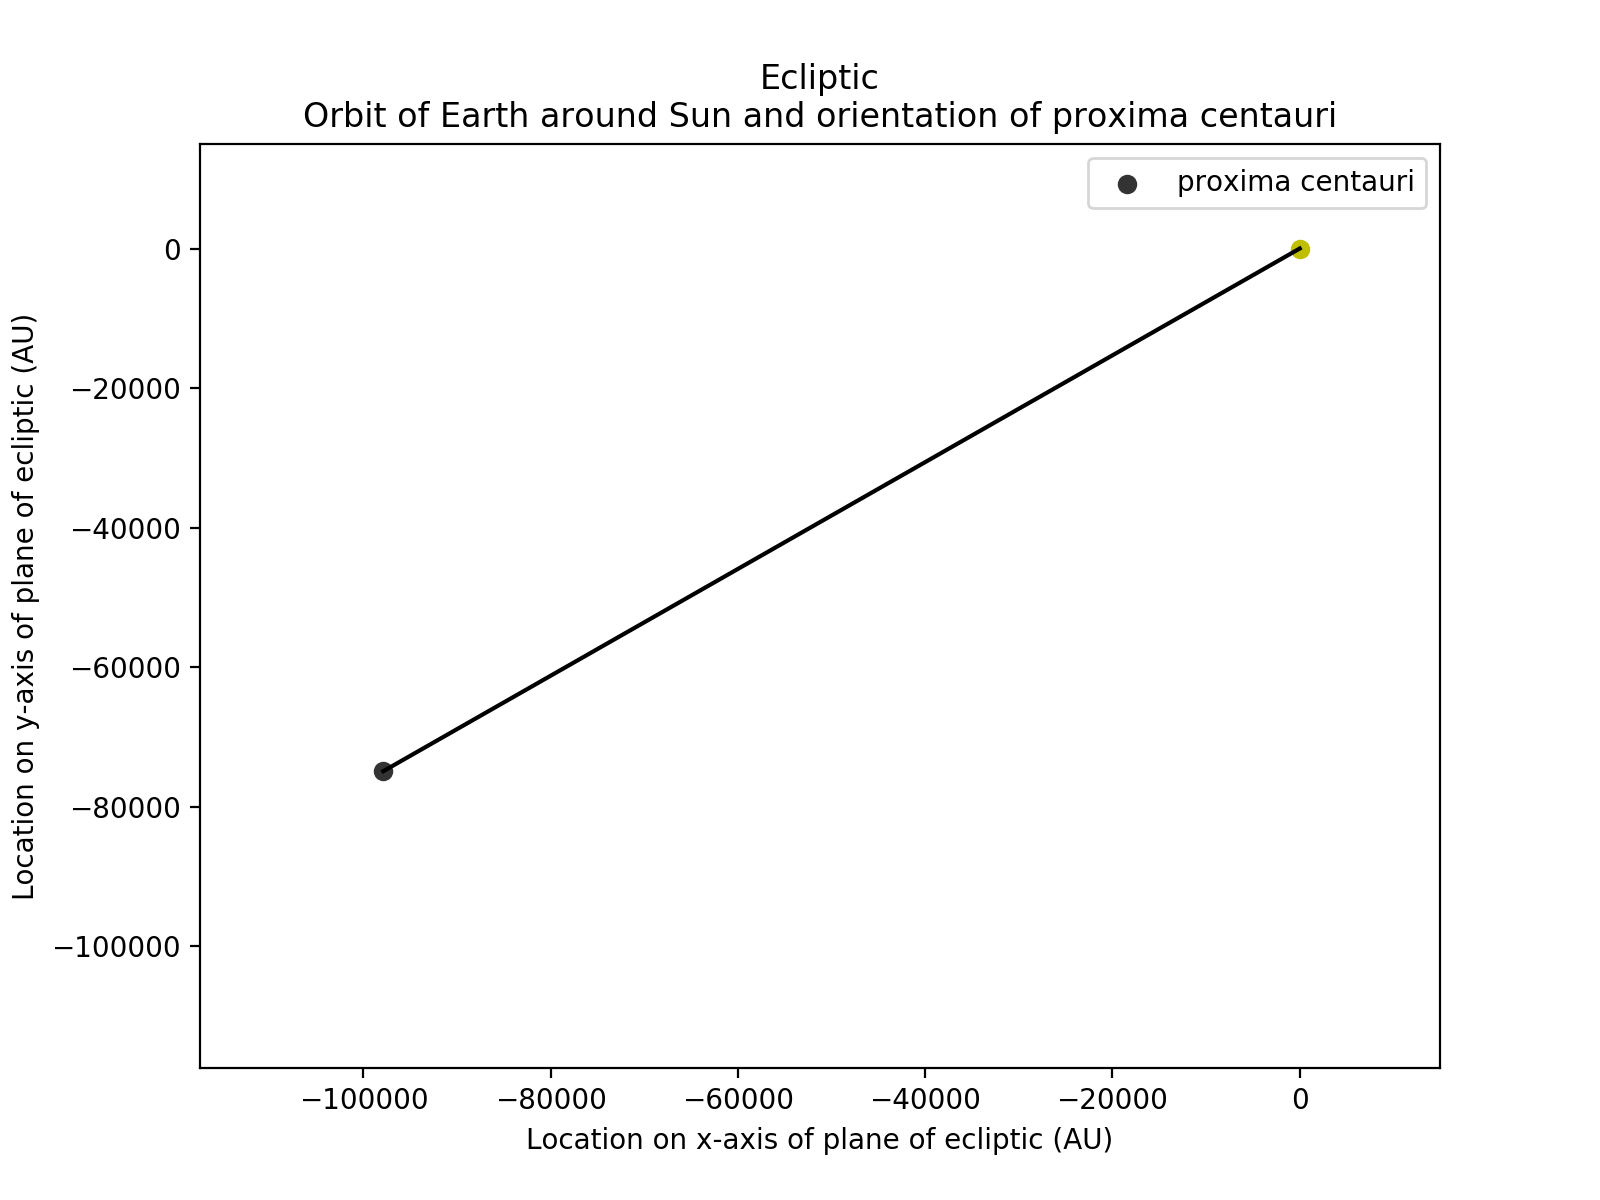

Text(0.5, 0, 'Location on x-axis of plane of ecliptic (AU)')

In [12]:
%matplotlib notebook
plt.figure(figsize = (8, 6))
ax = []
ax.append(sig_x.value)
ax.append(sig_y.value)
ax2.append(sig_z.value)
plt.plot(0, 0, 'yo')
plt.plot([0, sig_x.value], [0, sig_y.value], 'k')
plt.scatter(sig_x.value, sig_y.value, c = f'0.{i * 2}', label = soi)

for i in range(0, len(obs1.x), 1):
    if obs1.times[i] < Time(time_start) or obs1.times[i] > Time(time_end):
            continue
    x = -(obs1.x[i]/au).value
    y = -(obs1.y[i]/au).value
    plt.plot([x, x - obs1.xdot[i].value/5000], [y, y - obs1.ydot[i].value/5000], '0.8')
clr = 'b'

if np.array(ax).max() > 0 and np.array(ax).min() < 0:
    plt.xlim(np.array(ax).min() - np.fabs(np.array(ax).min() * 0.2), np.array(ax).max() + np.fabs(np.array(ax).max() * 0.2))
    plt.ylim(np.array(ax).min() - np.fabs(np.array(ax).min() * 0.2), np.array(ax).max() + np.fabs(np.array(ax).max() * 0.2))
elif np.array(ax).max() < 0 and np.array(ax).min() < 0:
    plt.xlim(np.array(ax).min() - np.fabs(np.array(ax).min() * 0.2), 0 + np.fabs(np.array(ax).max() * 0.2))
    plt.ylim(np.array(ax).min() - np.fabs(np.array(ax).min() * 0.2), 0 + np.fabs(np.array(ax).max() * 0.2))
elif np.array(ax).max() > 0 and np.array(ax).min() > 0:
    plt.xlim(0 - np.fabs(np.array(ax).min() * 0.2), np.array(ax).max() + np.fabs(np.array(ax).max() * 0.2))
    plt.ylim(0 - np.fabs(np.array(ax).min() * 0.2), np.array(ax).max() + np.fabs(np.array(ax).max() * 0.2))
plt.legend()
plt.title("Ecliptic\nOrbit of Earth around Sun and orientation of " + soi)
plt.ylabel("Location on y-axis of plane of ecliptic (AU)")
plt.xlabel("Location on x-axis of plane of ecliptic (AU)")


A zoomed in version of the plot above, centering on the yellow dot (the Sun):

<IPython.core.display.Javascript object>


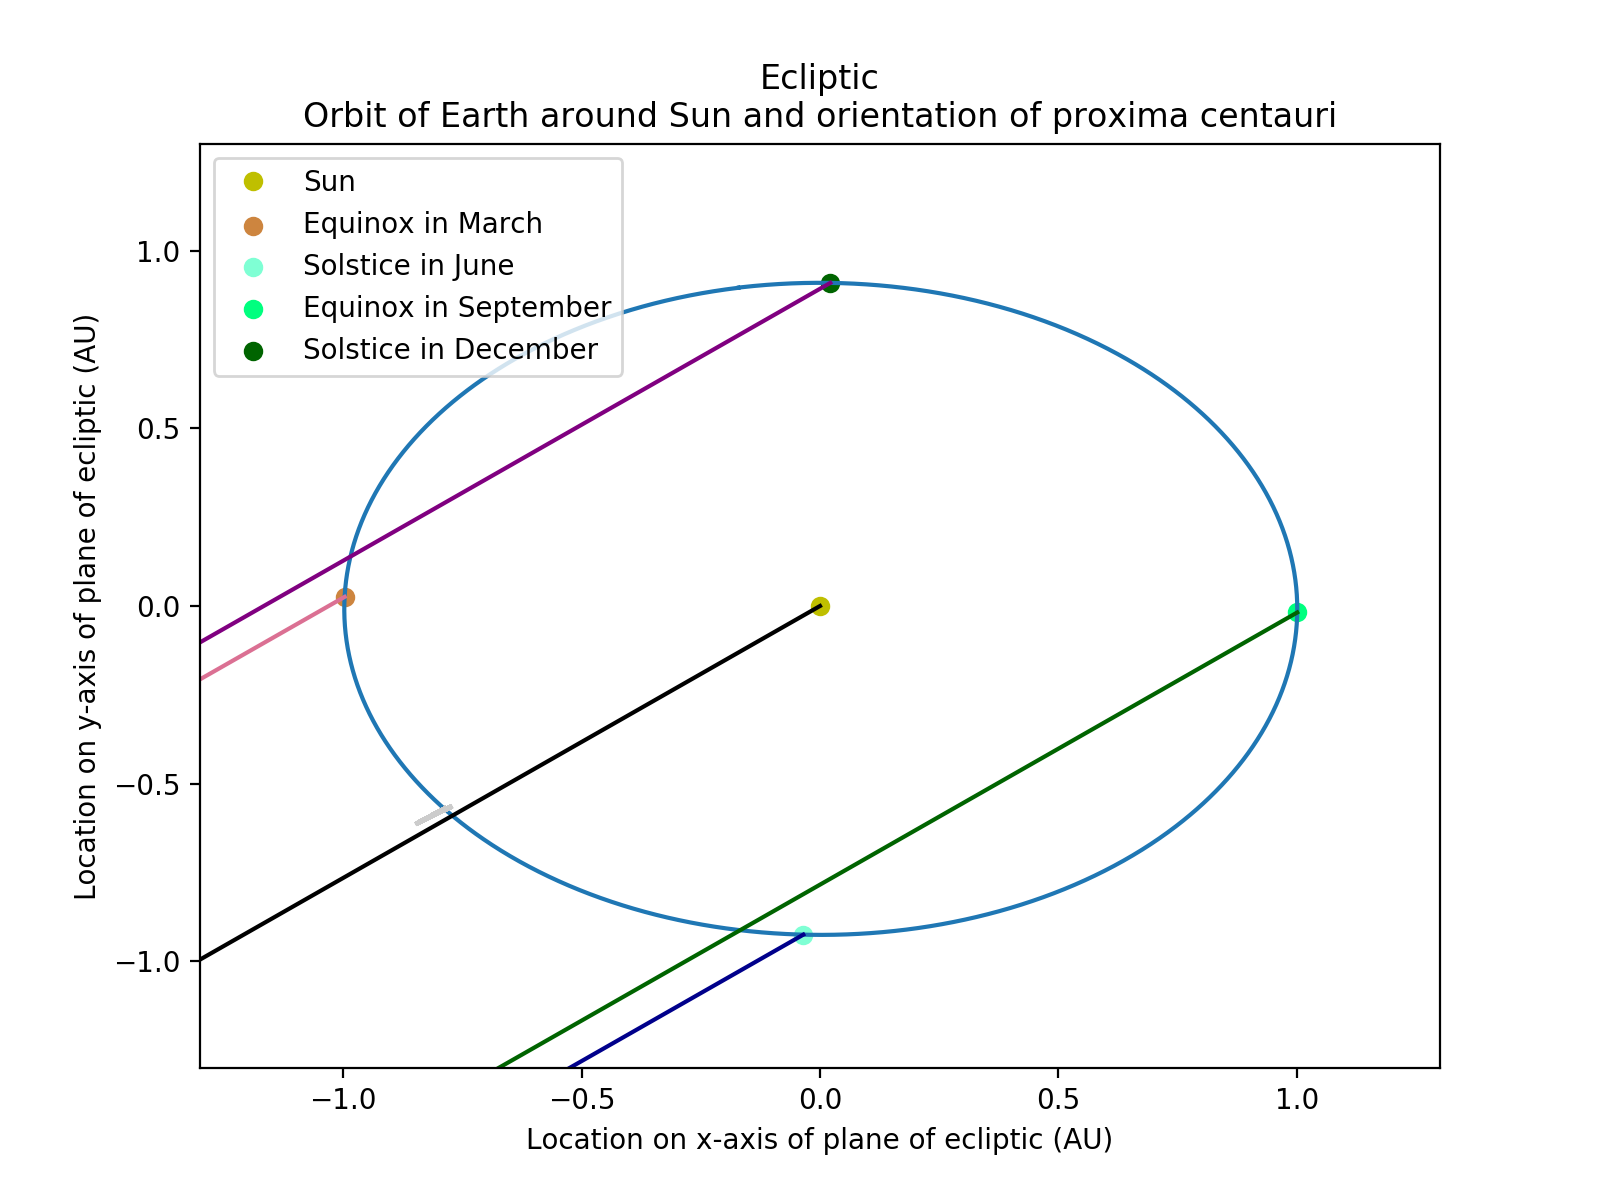

Text(0.5, 0, 'Location on x-axis of plane of ecliptic (AU)')

In [13]:
%matplotlib notebook
plt.figure(figsize = (8, 6))
obs1.at(time)

plt.scatter(gc.x[468]/gc.au, gc.y[468]/gc.au, color = 'peru', label = 'Equinox in March')
plt.scatter(gc.x[1020]/gc.au, gc.y[1020]/gc.au, color = 'aquamarine', label = 'Solstice in June')
plt.scatter(gc.x[1584]/gc.au, gc.y[1584]/gc.au, color = 'springgreen', label = 'Equinox in September')#\n(Autumnal in Northern\nHemisphere and Vernal in Southern Hemisphere)')
plt.scatter(gc.x[2124]/gc.au, gc.y[2124]/gc.au, color = 'darkgreen', label = 'Solstice in December')

plt.plot(gc.x/gc.au, gc.y/gc.au)
plt.plot(0, 0, 'yo', label = 'Sun')
plt.plot([0, sig_x.value], [0, sig_y.value], 'k')

plt.plot([gc.x[2124]/gc.au, sig_x.value], [gc.y[2124]/gc.au, sig_y.value], color = 'purple')
plt.plot([(gc.x/gc.au)[468], sig_x.value], [gc.y[468]/gc.au, sig_y.value], color = 'palevioletred')
plt.plot([(gc.x/gc.au)[1020], sig_x.value], [gc.y[1020]/gc.au, sig_y.value], color = 'darkblue')
plt.plot([(gc.x/gc.au)[1584], sig_x.value], [gc.y[1584]/gc.au, sig_y.value], color = 'darkgreen')

for i in range(0, len(obs1.x), 1):
    x = -(obs1.x[i]/au).value
    y = -(obs1.y[i]/au).value
    plt.plot([x, x - obs1.xdot[i].value/5000], [y, y - obs1.ydot[i].value/5000], '0.8')

if np.array(ax).max() > 0 and np.array(ax).min() < 0:
    plt.xlim(np.array(ax).min() - np.fabs(np.array(ax).min() * 0.2), np.array(ax).max() + np.fabs(np.array(ax).max() * 0.2))
    plt.ylim(np.array(ax).min() - np.fabs(np.array(ax).min() * 0.2), np.array(ax).max() + np.fabs(np.array(ax).max() * 0.2))
elif np.array(ax).max() < 0 and np.array(ax).min() < 0:
    plt.xlim(np.array(ax).min() - np.fabs(np.array(ax).min() * 0.2), 0 + np.fabs(np.array(ax).max() * 0.2))
    plt.ylim(np.array(ax).min() - np.fabs(np.array(ax).min() * 0.2), 0 + np.fabs(np.array(ax).max() * 0.2))
elif np.array(ax).max() > 0 and np.array(ax).min() > 0:
    plt.xlim(0 - np.fabs(np.array(ax).min() * 0.2), np.array(ax).max() + np.fabs(np.array(ax).max() * 0.2))
    plt.ylim(0 - np.fabs(np.array(ax).min() * 0.2), np.array(ax).max() + np.fabs(np.array(ax).max() * 0.2))
plt.xlim(-1.3, 1.3)
plt.legend(loc = 'upper left')
plt.ylim(-1.3, 1.3)
plt.ylabel("")
plt.title("Ecliptic\nOrbit of Earth around Sun and orientation of " + soi)
plt.ylabel("Location on y-axis of plane of ecliptic (AU)")
plt.xlabel("Location on x-axis of plane of ecliptic (AU)")

The plot above shows the orbit of the Earth around the Sun (blue line), as well as the direction (lines originating at the 5 points above) from the Earth to the Star at four different points in the year. The grey lines represent the rotation of the Earth at the time of observation.

The next plot shows the location of the star relative to the plane of the solar system.

Target body name: Solar System Barycenter (0)     {source: DE441}
Observers location: Parkes Radio Telescope 64-m
Start time      : A.D. 2019-Jan-01 00:00:00.0000 UT
Stop  time      : A.D. 2020-Jan-01 00:00:00.0000 UT
Step-size       : 240 minutes


<IPython.core.display.Javascript object>


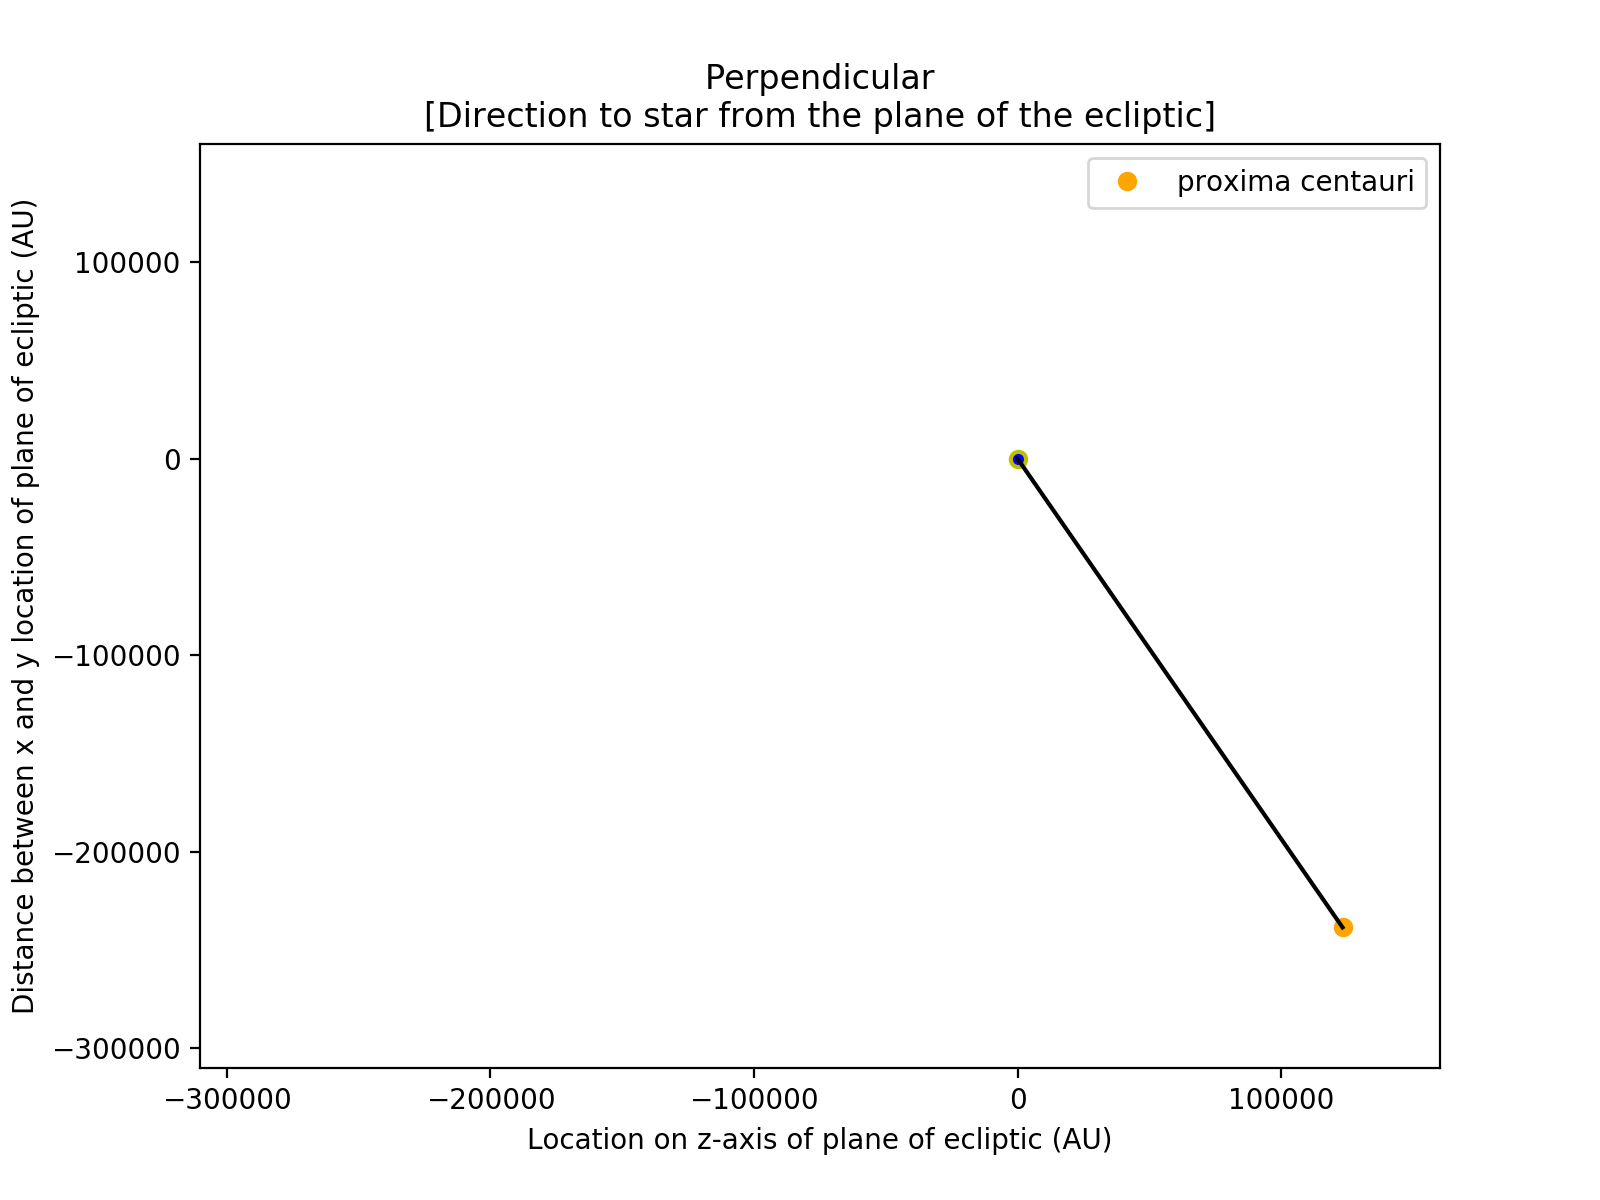

In [14]:
obs1 = horizons.Horizons(obs1_file)
plt.figure(figsize = (8, 6))
dperp = np.sqrt(obs1.x[0]**2 + obs1.y[0]**2) / gc.au
pperp = np.sqrt(sig_x.value**2 + sig_y.value**2)
plt.plot(pperp, sig_z.value, 'o', color='orange', label = soi)
plt.plot(0, 0, 'yo')
plt.plot(dperp, 0, 'b.')
plt.plot([0, dperp, pperp], [0, 0, sig_z.value], color = 'k')
ax2.append(pperp)
if np.array(ax2).min() < 0:
    plt.xlim(np.array(ax2).min() - np.fabs(np.array(ax2).min() * 0.3), np.array(ax2).max() + np.fabs(np.array(ax2).max() * 0.3))
    plt.ylim(np.array(ax2).min() - np.fabs(np.array(ax2).min() * 0.3), np.array(ax2).max() + np.fabs(np.array(ax2).max() * 0.3))
else:
    plt.xlim(0 - np.fabs(np.array(ax2).max() * 0.3), np.array(ax2).max() + np.fabs(np.array(ax2).max() * 0.3))
    plt.ylim(0 - np.fabs(np.array(ax2).max() * 0.3), np.array(ax2).max() + np.fabs(np.array(ax2).max() * 0.3))    
plt.legend()
plt.title('Perpendicular\n[Direction to star from the plane of the ecliptic]')
plt.ylabel("Distance between x and y location of plane of ecliptic (AU)")
plt.xlabel("Location on z-axis of plane of ecliptic (AU)")
plt.show()

The plots above are in two different frames, and the frames are projections of each other. The perpendicular plot uses $ \sqrt{x^2 + y^2} $ (the distance between the x and y points) as the x axis and the location of the star on the z axis (distance above the ecliptic) as the y axis. The ecliptic plot shows the location of the star on the y axis of the ecliptic vs the location of the star on the x axis of the ecliptic.

## Visualize what a signal would look like from the star based on two different assumptions

In this section, we will be simulating the waterfall plots that will show what incoming signals could look like if there were corrections made for drift.

First, we will define some terms that will be used in making our plots:

In [15]:
#Cannot be changed
dist = float(dis) * 9.461e15 #Conversion from lightyears to meters
c0 = gc.c0 #Constant (m/s^2)

#Can be changed
f = 900e6 #Hz
flo = -2000.0 #Hz
fhi = 2000.0 #Hz
bw = 1.0
minsmear = 4.0
Tsys = 20.0

- f = the central frequency of the waterfall plot in Hz. This should be the central frequency of the signal
- flo = the minimum frequency for the waterfall plot (in Hz) [also the minimum x-value]
- fhi = the maximum frequency for the waterfall plot (in Hz) [also the maximum x-value]
- bw = bandwidth of the signal. Used to calculate channel width
- minsmear = the lowest amount of smear you want the signal to have. Higher minsmear leads to wider signals
- Tsys = the temperature of the observer (telescope)

In [16]:
#Setting an array of 0s to use when plotting one signal on the waterfall 
ddot0 = [0] * len(obs_gcrs_Ddot) 

## Model 1: Assume the signal was sent intentionally to our solar system

If we assume that the signal we receive is extraterrestrial in origin, then we might also assume that whoever sent the signal had already corrected for the frequency drift due to the motion of their planet and star. Here, we are also assuming that it was sent intentionally to our solar system (specifically the Sun) so the drift for the motion of the barycenter is also corrected for.

<Waterfall setup>
	Nch: 4000, Ntimes: 1001
	flo: -2000.00 Hz, fhi: 2000.00 Hz, int_time: 21.6 s
<Adding 0>


<IPython.core.display.Javascript object>


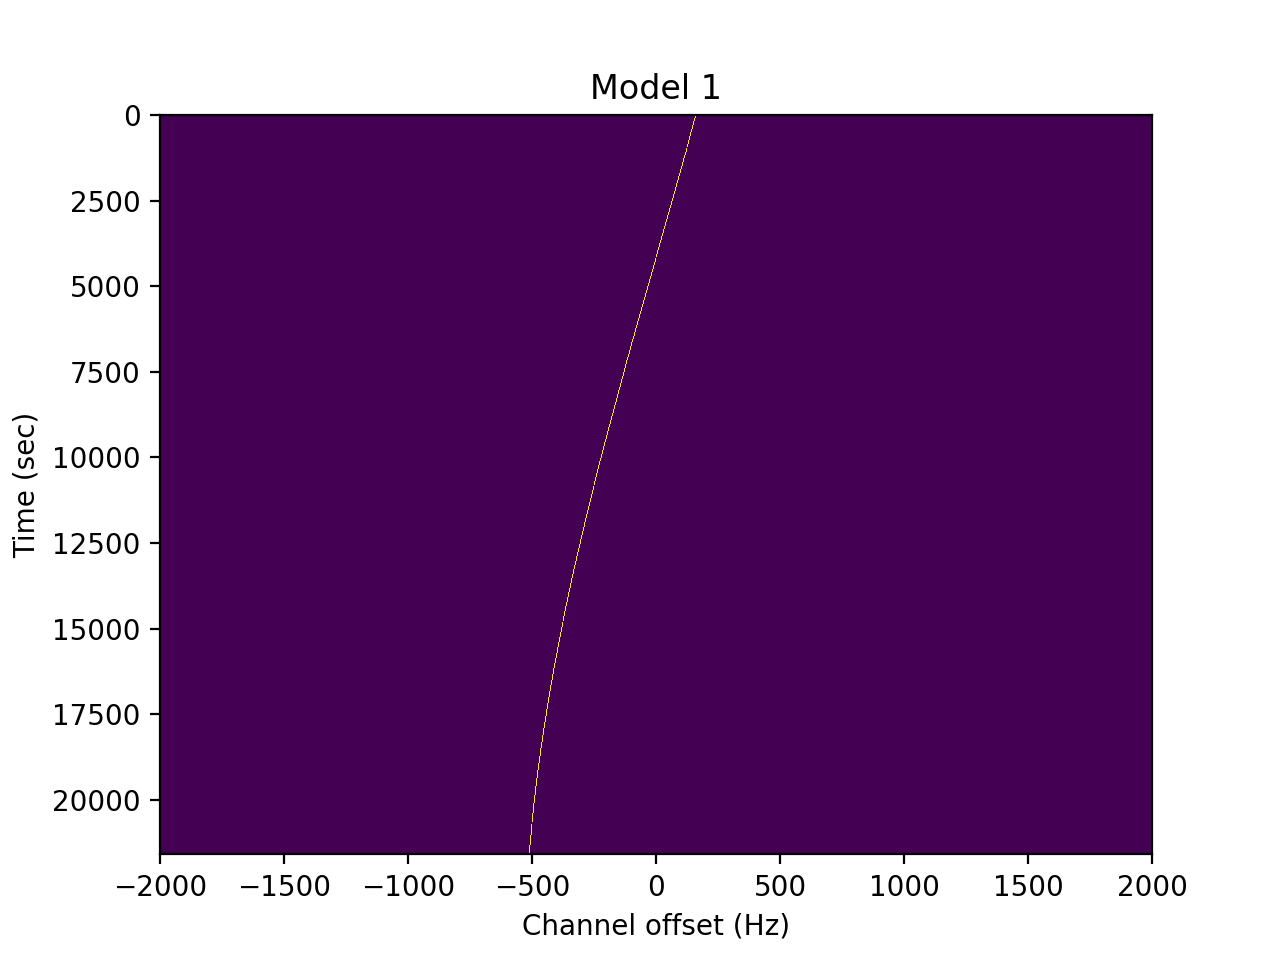

Text(0.5, 1.0, 'Model 1')

In [17]:
%matplotlib notebook
waterfall(f, time, Tsys, flo, fhi, bw, minsmear, obs_gcrs_Ddot, ddot0, 5, figname = 'waterfall', log = False)
plt.title('Model 1')

Now, we'll plot the velocity of the frequency offset (Hz/s) vs time (in seconds) for model 1 to show how the change of frequency (velocity) changes in time. This is also a good check to see if the change of frequency in time makes sense with the waterfall plot.

<IPython.core.display.Javascript object>


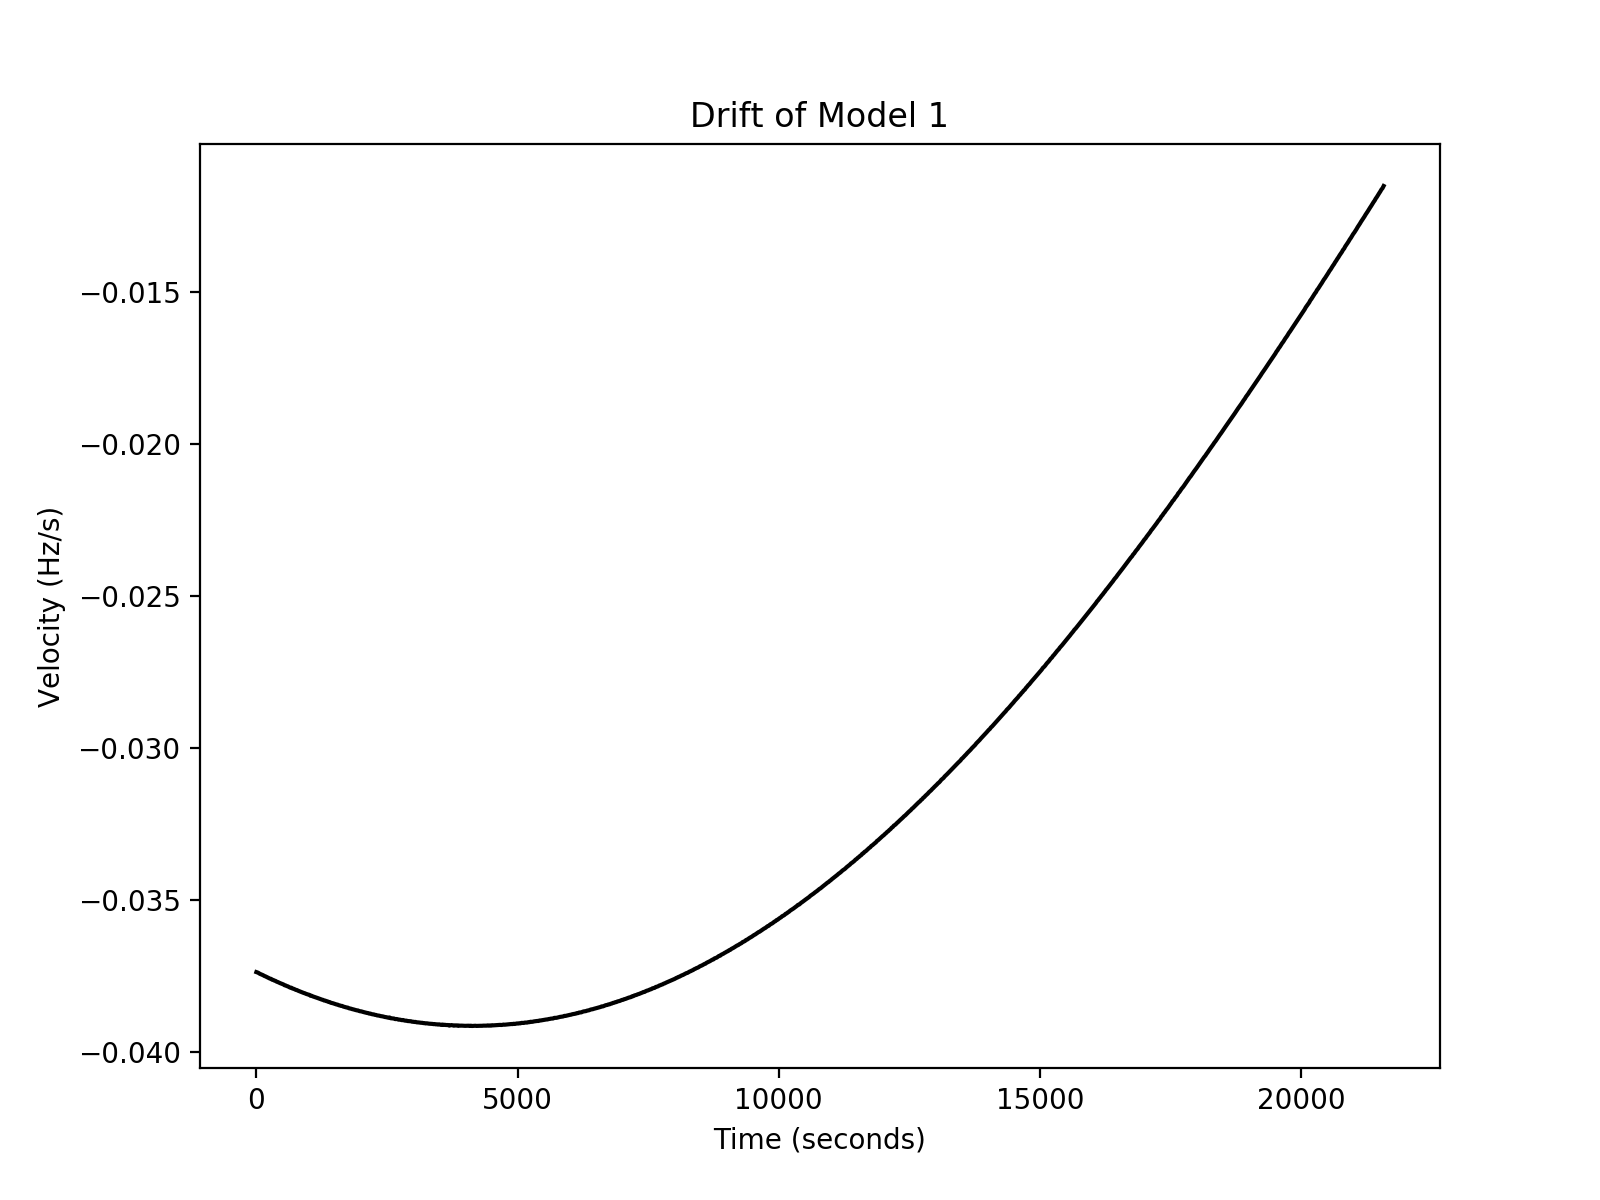

Text(0.5, 1.0, 'Drift of Model 1')

In [18]:
drift_gcrs = (f*(obs_gcrs_Ddotdot.value)/c0).value
plt.figure(figsize = (8, 6))
plt.plot(sec[0:-1], drift_gcrs, color = 'k')
plt.ylabel("Velocity (Hz/s)")
plt.xlabel('Time (seconds)')
plt.title('Drift of Model 1')

## Model 2: Assume the signal was sent intentionally to the Earth

We are assuming, in addition to the assumptions made in model 1, that the signal was sent intentionally to the Earth (this might be because they knew that it is inhabited) and so the drift due to the Earth's orbit has already been accounted for. The only thing we are looking at is the drift due to the rotation of the Earth around its axis at the location of the observer.

In [19]:
#We need to make sure that the data looking at Earth from the Solar System Barycenter is given for the right timeframe
gcd.at(time)

<Waterfall setup>
	Nch: 4000, Ntimes: 1001
	flo: -2000.00 Hz, fhi: 2000.00 Hz, int_time: 21.6 s
<Adding 0>


<IPython.core.display.Javascript object>


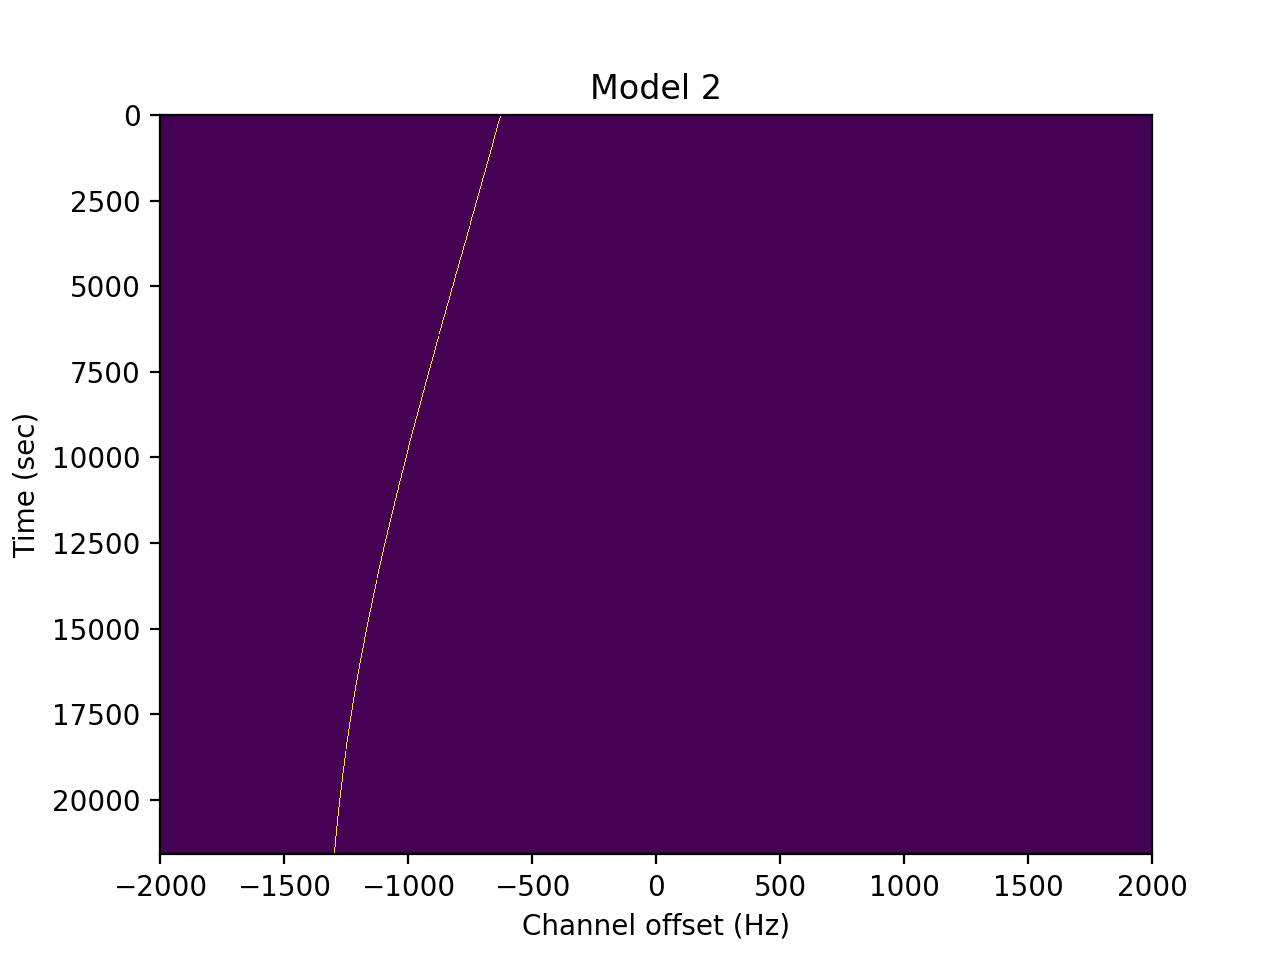

Text(0.5, 1.0, 'Model 2')

In [22]:
%matplotlib notebook
waterfall(f, time, Tsys, flo, fhi, bw, minsmear, obs_gcrs_Ddot - gcd.Ddot, ddot0, 5, figname = 'waterfall', log = False)
plt.title('Model 2')

Now, we're going to plot the velocity of the frequency offset (Hz/s) vs time (in seconds) again, but this time for model 2.

<IPython.core.display.Javascript object>


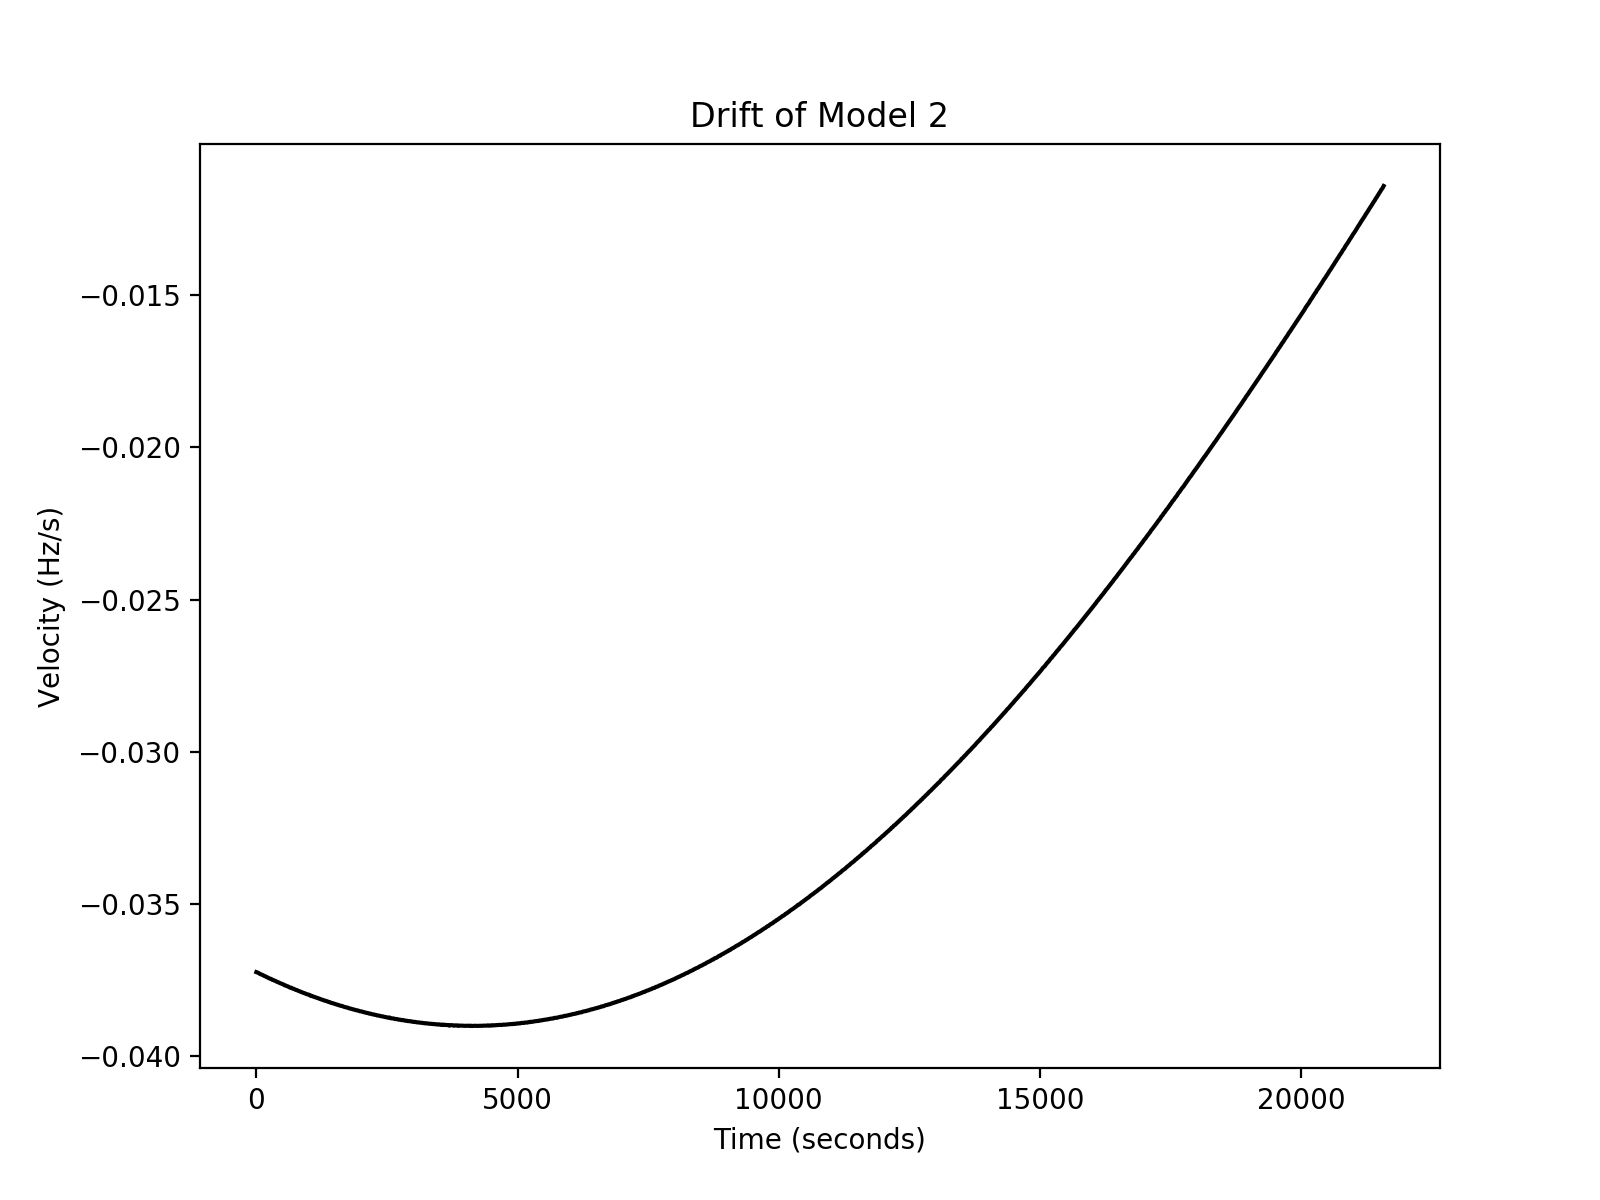

Text(0.5, 1.0, 'Drift of Model 2')

In [23]:
%matplotlib notebook
drift_obs = (f*(obs_gcrs_Ddotdot.value - gcd.Ddotdot[0:-1].value)/obs1.c0).value
plt.figure(figsize = (8, 6))
plt.plot(sec[0:-1], (drift_obs), color = 'k')
plt.ylabel("Velocity (Hz/s)")
plt.xlabel('Time (seconds)')
plt.title('Drift of Model 2')

## Stacked drift plot

Here, you can compare the frequency offset as well as the velocities for both of the models.

First, you can plot the waterfall for both of the signals at the same time:

<Waterfall setup>
	Nch: 4000, Ntimes: 1001
	flo: -2000.00 Hz, fhi: 2000.00 Hz, int_time: 21.6 s
<Adding 0>


<IPython.core.display.Javascript object>


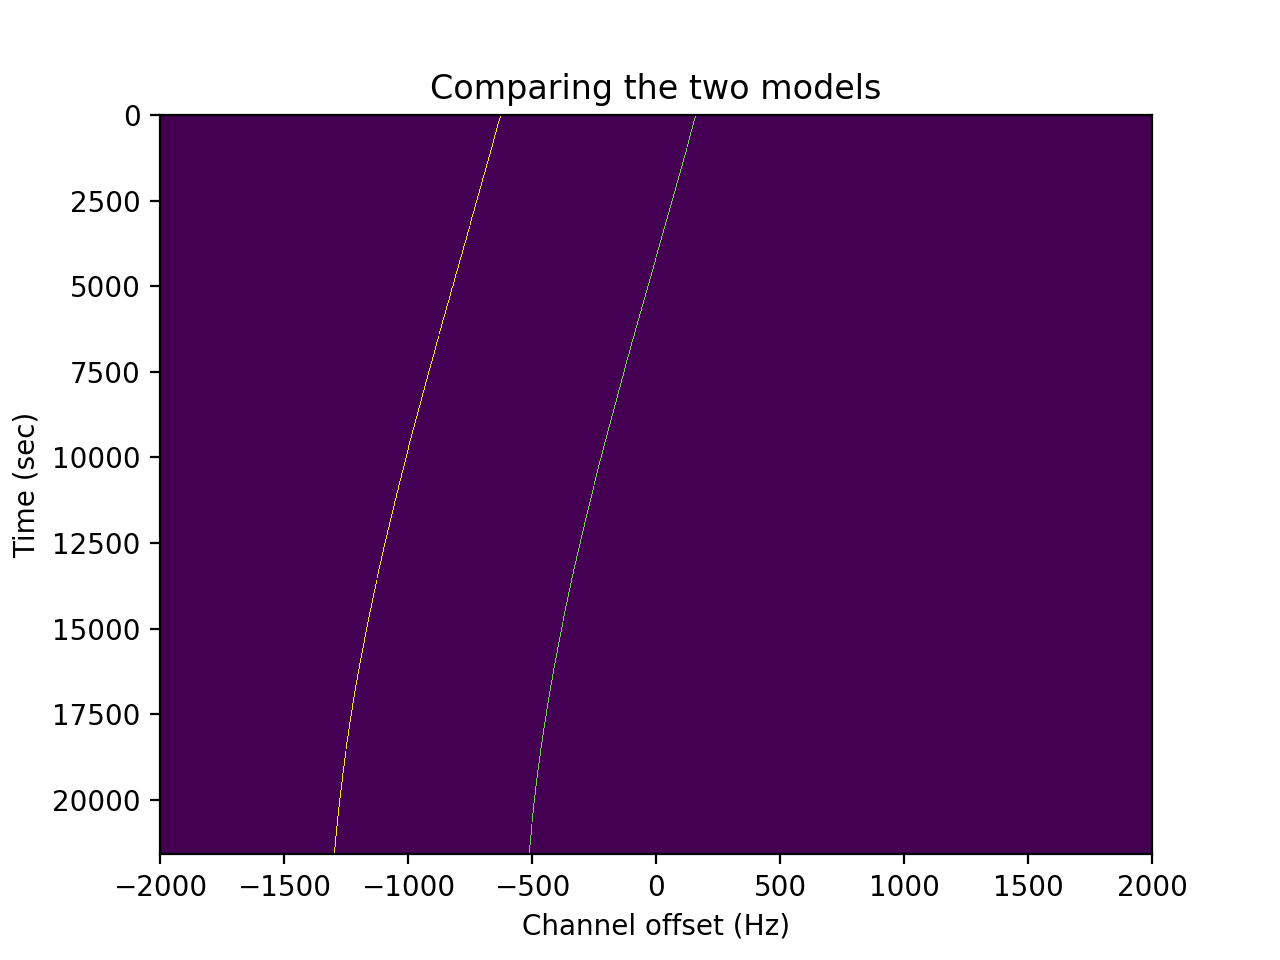

Text(0.5, 1.0, 'Comparing the two models')

In [24]:
%matplotlib notebook
waterfall(f, time, 20.0, flo, fhi, bw, minsmear, obs_gcrs_Ddot, obs_gcrs_Ddot - gcd.Ddot, 5)
plt.title("Comparing the two models")

The signal with more yellow in it is the one at Ddot2 (here, it's the offset of the observer location).

Next, you'll be able to see the difference between the drift of model 1 (correcting for barycenter) and model 2 (correcting for both barycenter and geocenter). The difference is small, so it'll be easier to see if you zoom in.

<IPython.core.display.Javascript object>


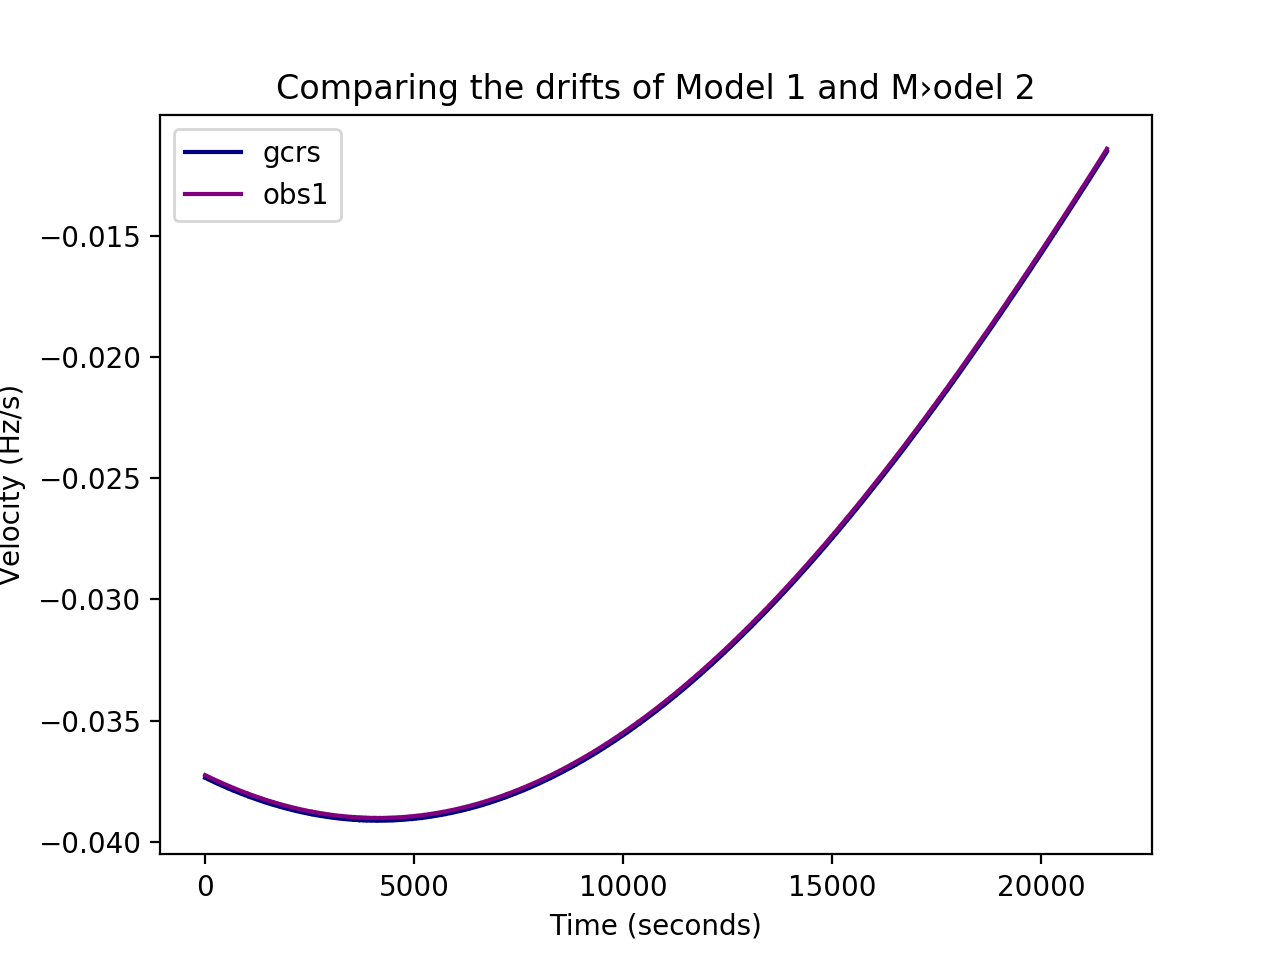

In [25]:
plt.figure()
plt.plot(sec[0:-1], drift_gcrs, 'navy', label = 'gcrs')
plt.plot(sec[0:-1], drift_obs, 'purple', label = 'obs1')
plt.xlabel('Time (seconds)')
plt.ylabel("Velocity (Hz/s)")
plt.title("Comparing the drifts of Model 1 and M›odel 2")
plt.legend()

## Show how altitude and azimuth changes over the time period

Altitude and azimuth both change throughout the day due to the rotation of the Earth. They also vary throughout the year from the orbit of the Earth around the Sun. 

Depending on the latitude of the observer, there are some stars that will never be seen, and others that will never set. Let's say that the latitude of the observer is +30$^\circ$: all stars within 30$^\circ$ of the South celestial pole will never rise at this location and all stars within 30$^\circ$ of the North celestial pole (Polaris) will never set (they're <b>circumpolar</b>).

<IPython.core.display.Javascript object>


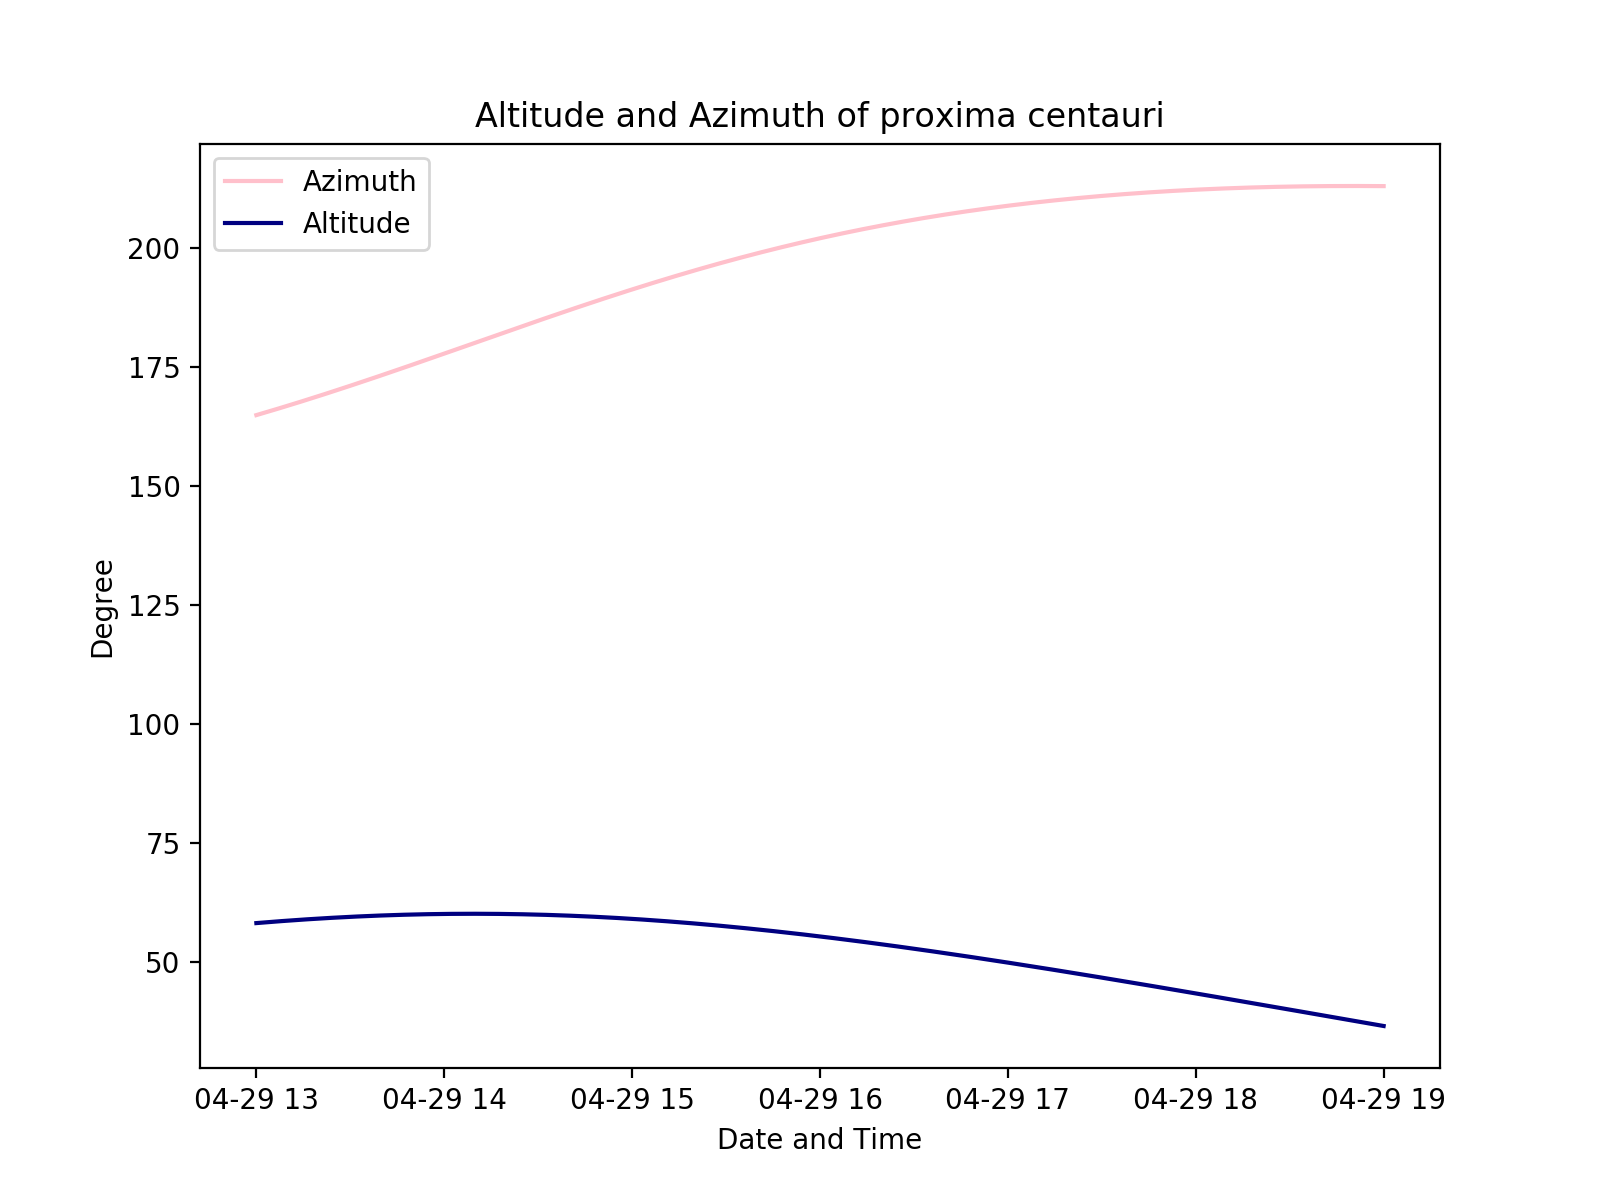

In [26]:
plt.figure(figsize = (8, 6))
plt.plot(time.value, obs_az, color = 'pink', label = 'Azimuth')
plt.plot(time.value, obs_el, color = 'navy', label = "Altitude")
plt.xlabel("Date and Time")
plt.ylabel("Degree")
plt.title(f'Altitude and Azimuth of {soi}')
plt.legend()

### If you observed a signal, you can compare the drift of the signal with the drift of the two different models

If observed a signal of interest was observed, here you can visually compare whether the change of frequency in time of the signal is the same as that of either of the models. If it is, then it is possible that the signal is extraterrestrial in origin.

Below, you'll be prompted to manually input the number of times the telescope was pointed at the signal, the start date and time of each of the observations, the drift, and the error of the velocity in the x axis.

In [ ]:
ntimes = input('Input number of on-times the signal was observed: ')
times = []
drift_sig = []
err = []
for i in range(int(ntimes)):
    times.append(input("Input the start date and time (yyyy-mm-dd hh:mm:ss): "))
    drift_sig.append(float(input("Input the observed drift at that time: ")))
    err.append(drift_sig[i] * float(input("Input the observed error in drift at that time: "))/100.0)
times = Time(times)
tspan = (mdates.date2num(times[1].datetime) - mdates.date2num(times[0].datetime))/2

Below is the plot of the change in frequency (in units of Hz/s) vs time (in units of month-day-hour). On the plot is the signal drift (with error bars), the drift of model 1, and the drift of model 2. It isn't easy to see the differences between the two corrections, but it's clear when you zoom in.

In [ ]:
%matplotlib notebook
#plt.s
plt.figure('drift')
plt.plot(time.value[0:-1], drift_gcrs, label = 'Model 1', color = 'darkgrey')
plt.plot(time.value[0:-1], drift_obs, label = 'Model 2', color = 'darkgreen')
plt.errorbar(mdates.date2num(times.datetime), drift_sig, err, tspan, fmt='k.', capsize=10)
plt.plot(times.datetime, drift_sig, 'ko', label = 'signal')
plt.legend(loc = 'upper right')
plt.xlabel('Time [month-day hr]')
plt.ylabel('Velocity (Hz/s)')
plt.title("Drift of the signal, Model 1, and Model 2")

### Compare the drifts from two different stars

Now, you can compare the drift from the simulated signal of interest with the drift of a simulated signal from another star. The goal of this is to see how the location of the star on the sky affects the drift we see. To get a good idea of by how much drift can vary, choose a star that's in a different section on the sky.

To start, we're going to run the code to get right ascension, the declination, the cartesian coordinates of the star, the geocentric and barycentric distance, the change of distance in time, and the change of velocity in time like we did at the beginning, but this time with a different target star.

In [27]:
soi2 = input("Name of star to look at or Custom (for specific ra and dec): ")
if soi2 == "Custom" or soi2 == 'custom':
    ra_s2 = input("Right ascension [degrees (0, 360)] (... ..'..''): ")
    dec_s2 = input("Declination [degrees (-90, 90)] (±.. ..'..''): ")
    if len(ra_s2) < 11 or len(dec_s2) < 10:
        print("Please make sure you put right ascension and declination in right (run again)")
        #break
    ra2 = float(ra_s2[0:3]) + float(ra_s2[4:6])/60.0 + float(ra_s2[7:-2])/3600.0
    if dec_s2[0] == '-':
        dec2 = -1.0 * (float(dec_s2[1:3]) + float(dec_s2[4:6])/60.0 + float(dec_s2[7:-2])/3600.0)
    elif dec_s2[0] == '+':
        dec2 = +1.0 * float(dec_s2[1:3]) + float(dec_s2[4:6])/60.0 + float(dec_s2[7:-2])/3600.0
if soi2 != "Custom" and soi2 != "custom":
    s2 = SkyCoord.from_name(soi2, frame = 'gcrs')
    ra2 = s2.ra.deg
    dec2 = s2.dec.deg   
dis2 = input("Distance to star (in ly [look up]): ")

Name of star to look at or Custom (for specific ra and dec): Iota Cassiopeiae
Distance to star (in ly [look up]): 4.50


In [28]:
d2 = (float(dis2)*ly/au)

sig_x2 = d2 * np.cos(np.deg2rad(ra2))*np.cos(np.deg2rad(dec2))
sig_y2 = d2 * np.sin(np.deg2rad(ra2))*np.cos(np.deg2rad(dec2))
sig_z2 = d2 * np.sin(np.deg2rad(dec2))

# Geocenter
obs_gcrs_D2 = (sig_x2/d2) * obs_gcrs_r.x + (sig_y2/d2) * obs_gcrs_r.y + (sig_z2/d2) * obs_gcrs_r.z
obs_gcrs_Ddot2 = (sig_x2/d2) * obs_gcrs_v.x + (sig_y2/d2) * obs_gcrs_v.y + (sig_z2/d2) * obs_gcrs_v.z
obs_gcrs_Ddotdot2 = diff(obs_gcrs_Ddot2) / diff(sec * u.s)

#Barycenter
obs_icrs_Ddot2 = (sig_x2/d2) * obs_icrs_v_x + (sig_y2/d2) * obs_icrs_v_y + (sig_z2/d2) * obs_icrs_v_z
obs_icrs_Ddotdot2 = diff(obs_icrs_Ddot2) / diff(sec * u.s)

First, we can look at how the relative location of the signal source compares to that of the simulated signal source. (If it looks like there is only one star, zoom in on the Sun. It's likely that one source is significantly closer to the Sun than the other one, so it's harder to see.)

<IPython.core.display.Javascript object>


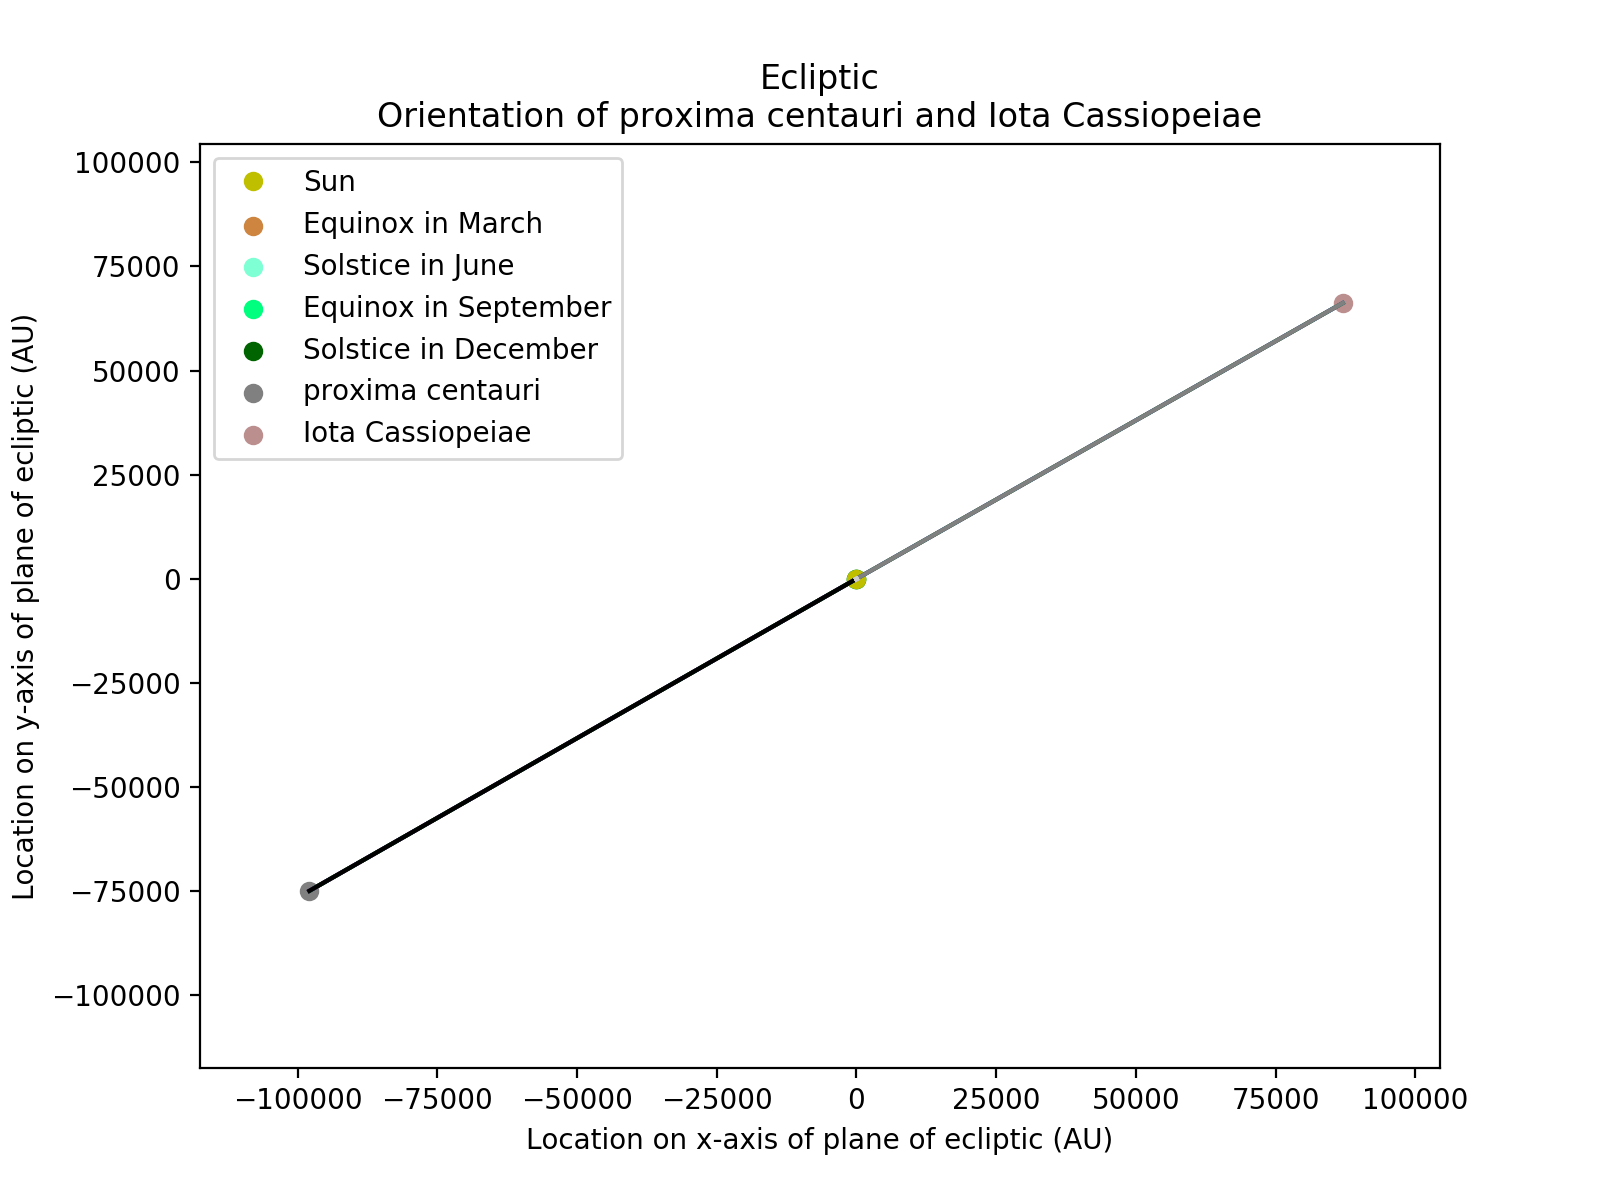

Text(0.5, 0, 'Location on x-axis of plane of ecliptic (AU)')

In [29]:
%matplotlib notebook
plt.figure(figsize = (8, 6))
obs1.at(time)
ax.append(sig_x2.value)
ax.append(sig_y2.value)
ax2.append(sig_z2.value)
plt.scatter(gc.x[468]/gc.au, gc.y[468]/gc.au, color = 'peru', label = 'Equinox in March')
plt.scatter(gc.x[1020]/gc.au, gc.y[1020]/gc.au, color = 'aquamarine', label = 'Solstice in June')
plt.scatter(gc.x[1584]/gc.au, gc.y[1584]/gc.au, color = 'springgreen', label = 'Equinox in September')#\n(Autumnal in Northern\nHemisphere and Vernal in Southern Hemisphere)')
plt.scatter(gc.x[2124]/gc.au, gc.y[2124]/gc.au, color = 'darkgreen', label = 'Solstice in December')
plt.plot(gc.x/gc.au, gc.y/gc.au)
plt.plot(0, 0, 'yo', label = 'Sun')
plt.plot([gc.x[2124]/gc.au, sig_x.value], [gc.y[2124]/gc.au, sig_y.value], color = 'purple')
plt.plot([(gc.x/gc.au)[468], sig_x.value], [gc.y[468]/gc.au, sig_y.value], color = 'palevioletred')
plt.plot([(gc.x/gc.au)[1020], sig_x.value], [gc.y[1020]/gc.au, sig_y.value], color = 'darkblue')
plt.plot([(gc.x/gc.au)[1584], sig_x.value], [gc.y[1584]/gc.au, sig_y.value], color = 'darkgreen')
plt.plot([gc.x[2124]/gc.au, sig_x2.value], [gc.y[2124]/gc.au, sig_y2.value], color = 'thistle')
plt.plot([(gc.x/gc.au)[468], sig_x2.value], [gc.y[468]/gc.au, sig_y2.value], color = 'pink')
plt.plot([(gc.x/gc.au)[1020], sig_x2.value], [gc.y[1020]/gc.au, sig_y2.value], color = 'mediumblue')
plt.plot([(gc.x/gc.au)[1584], sig_x2.value], [gc.y[1584]/gc.au, sig_y2.value], color = 'forestgreen')
for i in range(0, len(obs1.x), 1):
    x = -(obs1.x[i]/au).value
    y = -(obs1.y[i]/au).value
    plt.plot([x, x - obs1.xdot[i].value/5000], [y, y - obs1.ydot[i].value/5000], '0.8')
clr = 'b'
plt.plot([0, sig_x.value], [0, sig_y.value], 'k')
plt.plot([0, sig_x2.value], [0, sig_y2.value], 'grey')
plt.scatter(sig_x.value, sig_y.value, c = 'grey', label = soi)
plt.scatter(sig_x2.value, sig_y2.value, c = 'rosybrown', label = soi2)

for i in range(0, len(obs1.x), 1):
    if obs1.times[i] < Time(time_start) or obs1.times[i] > Time(time_end):
            continue
    x = -(obs1.x[i]/au).value
    y = -(obs1.y[i]/au).value
    plt.plot([x, x - obs1.xdot[i].value/5000], [y, y - obs1.ydot[i].value/5000], '0.8')

if np.array(ax).max() > 0 and np.array(ax).min() < 0:
    plt.xlim(np.array(ax).min() - np.fabs(np.array(ax).min() * 0.2), np.array(ax).max() + np.fabs(np.array(ax).max() * 0.2))
    plt.ylim(np.array(ax).min() - np.fabs(np.array(ax).min() * 0.2), np.array(ax).max() + np.fabs(np.array(ax).max() * 0.2))
elif np.array(ax).max() < 0 and np.array(ax).min() < 0:
    plt.xlim(np.array(ax).min() - np.fabs(np.array(ax).min() * 0.2), 0 + np.fabs(np.array(ax).max() * 2))
    plt.ylim(np.array(ax).min() - np.fabs(np.array(ax).min() * 0.2), 0 + np.fabs(np.array(ax).max() * 2))
elif np.array(ax).max() > 0 and np.array(ax).min() > 0:
    plt.xlim(0 - np.fabs(np.array(ax).min() * 0.2), np.array(ax).max() + np.fabs(np.array(ax).max() * 0.2))
    plt.ylim(0 - np.fabs(np.array(ax).min() * 0.2), np.array(ax).max() + np.fabs(np.array(ax).max() * 0.2))

plt.legend(loc = 'best')
plt.title("Ecliptic\nOrientation of " + soi + " and " + soi2)
plt.ylabel("Location on y-axis of plane of ecliptic (AU)")
plt.xlabel("Location on x-axis of plane of ecliptic (AU)")

Next, we're going to plot the orientation of our two signals on a projected coordinate system. Again, if it looks like there is only one star, zoom in on the Sun. It's likely that one source is significantly closer to the Sun than the other one, so it's harder to see.

Target body name: Solar System Barycenter (0)     {source: DE441}
Observers location: Parkes Radio Telescope 64-m
Start time      : A.D. 2019-Jan-01 00:00:00.0000 UT
Stop  time      : A.D. 2020-Jan-01 00:00:00.0000 UT
Step-size       : 240 minutes


<IPython.core.display.Javascript object>


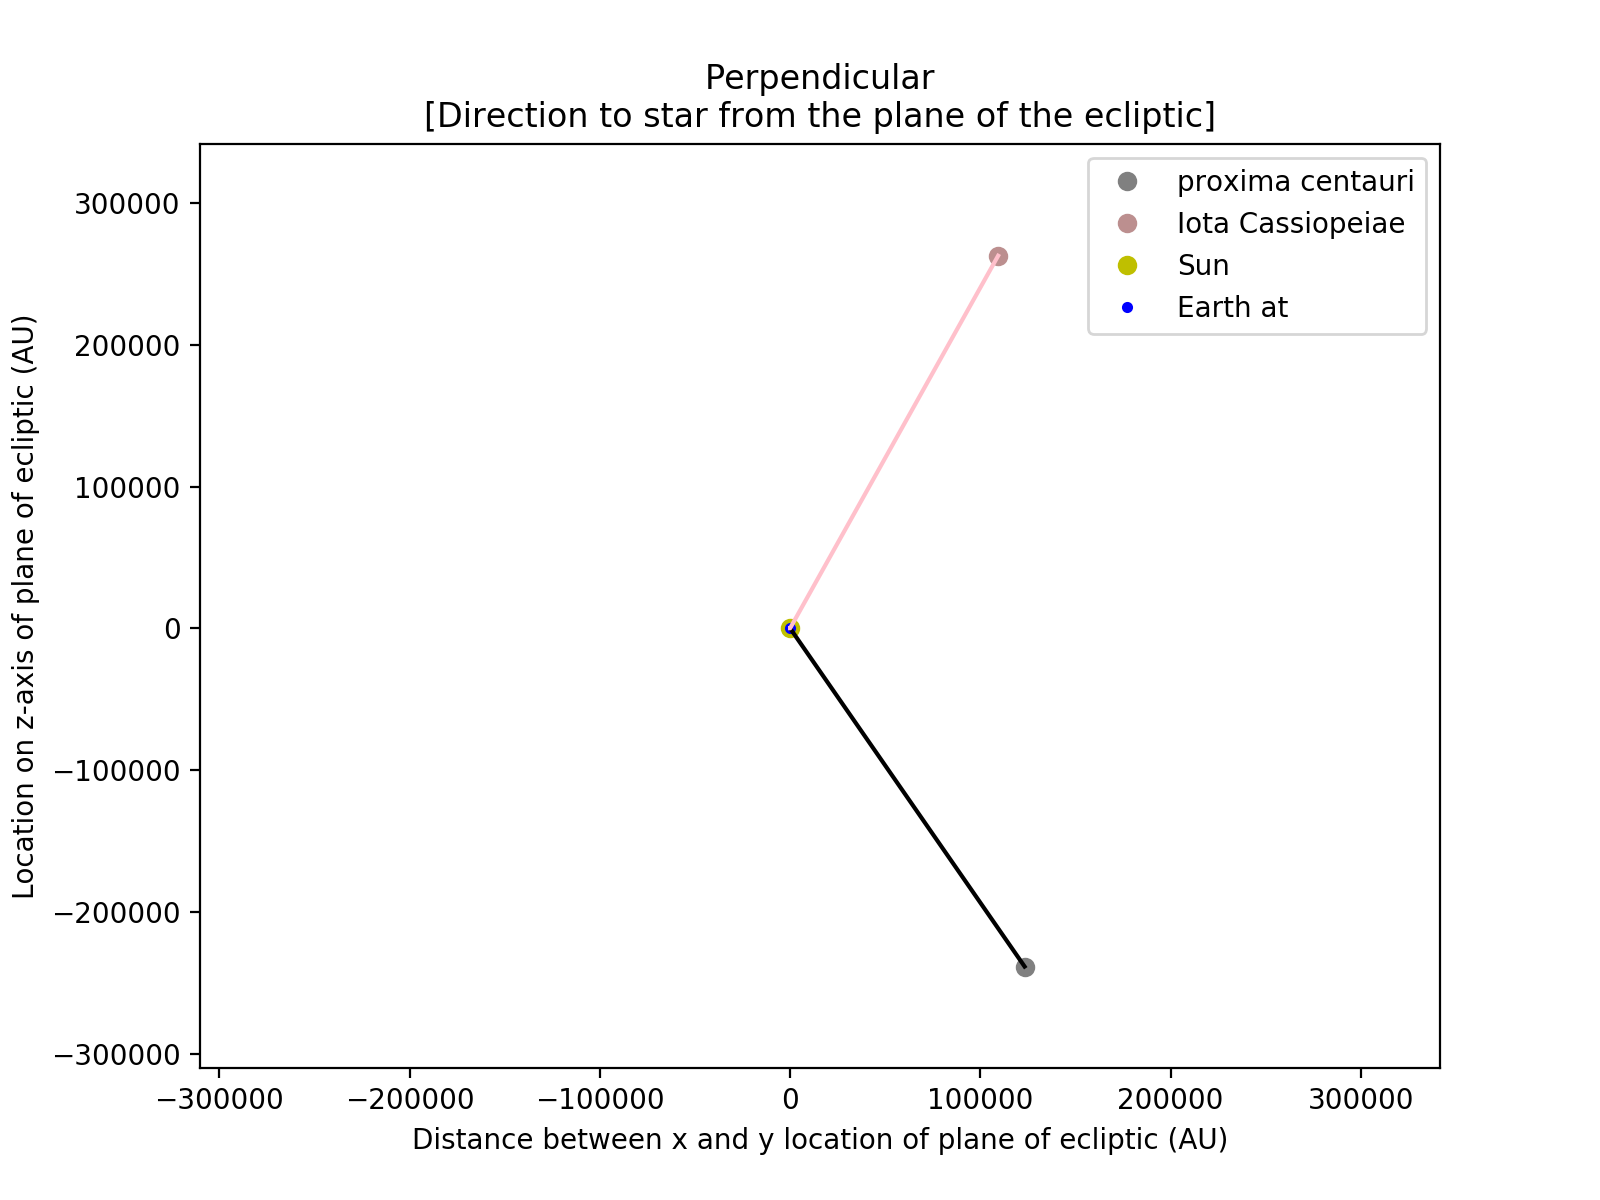

In [32]:
obs1 = horizons.Horizons(obs1_file)
plt.figure(figsize = (8, 6))
ax2 = []
dperp = np.sqrt(obs1.x[0]**2 + obs1.y[0]**2) / gc.au
pperp1 = np.sqrt(sig_x.value**2 + sig_y.value**2)
pperp2 = np.sqrt(sig_x2.value**2 + sig_y2.value**2)
plt.plot(pperp1, sig_z.value, 'o', color='grey', label = soi)
plt.plot(pperp2, sig_z2.value, 'o', color='rosybrown', label = soi2)
plt.plot(0, 0, 'yo', label = 'Sun')
plt.plot(dperp, 0, 'b.', label = 'Earth at ')
plt.plot([0, dperp, pperp1], [0, 0, sig_z.value], color = 'k')
plt.plot([0, dperp, pperp2], [0, 0, sig_z2.value], color = 'pink')
ax2.append(pperp1)
ax2.append(pperp2)
ax2.append(sig_z.value)
ax2.append(sig_z2.value)
if np.array(ax2).min() < 0:
    plt.xlim(np.array(ax2).min() - np.fabs(np.array(ax2).min() * 0.3), np.array(ax2).max() + np.fabs(np.array(ax2).max() * 0.3))
    plt.ylim(np.array(ax2).min() - np.fabs(np.array(ax2).min() * 0.3), np.array(ax2).max() + np.fabs(np.array(ax2).max() * 0.3))
else:
    plt.xlim(0 - np.fabs(np.array(ax2).max() * 0.3), np.array(ax2).max() + np.fabs(np.array(ax2).max() * 0.3))
    plt.ylim(0 - np.fabs(np.array(ax2).max() * 0.3), np.array(ax2).max() + np.fabs(np.array(ax2).max() * 0.3))    
plt.legend()
plt.title('Perpendicular\n[Direction to star from the plane of the ecliptic]')
plt.xlabel("Distance between x and y location of plane of ecliptic (AU)")
plt.ylabel("Location on z-axis of plane of ecliptic (AU)")
plt.show()

Next, we're going to create waterfall plots to compare the frequency offset of the signal source with that of another star. The signal from the second source (Ddot2) is the one that has more yellow in it. To start, we're going to plot model 1 for both sources:

<Waterfall setup>
	Nch: 4000, Ntimes: 1001
	flo: -2000.00 Hz, fhi: 2000.00 Hz, int_time: 21.6 s
<Adding 0>


<IPython.core.display.Javascript object>


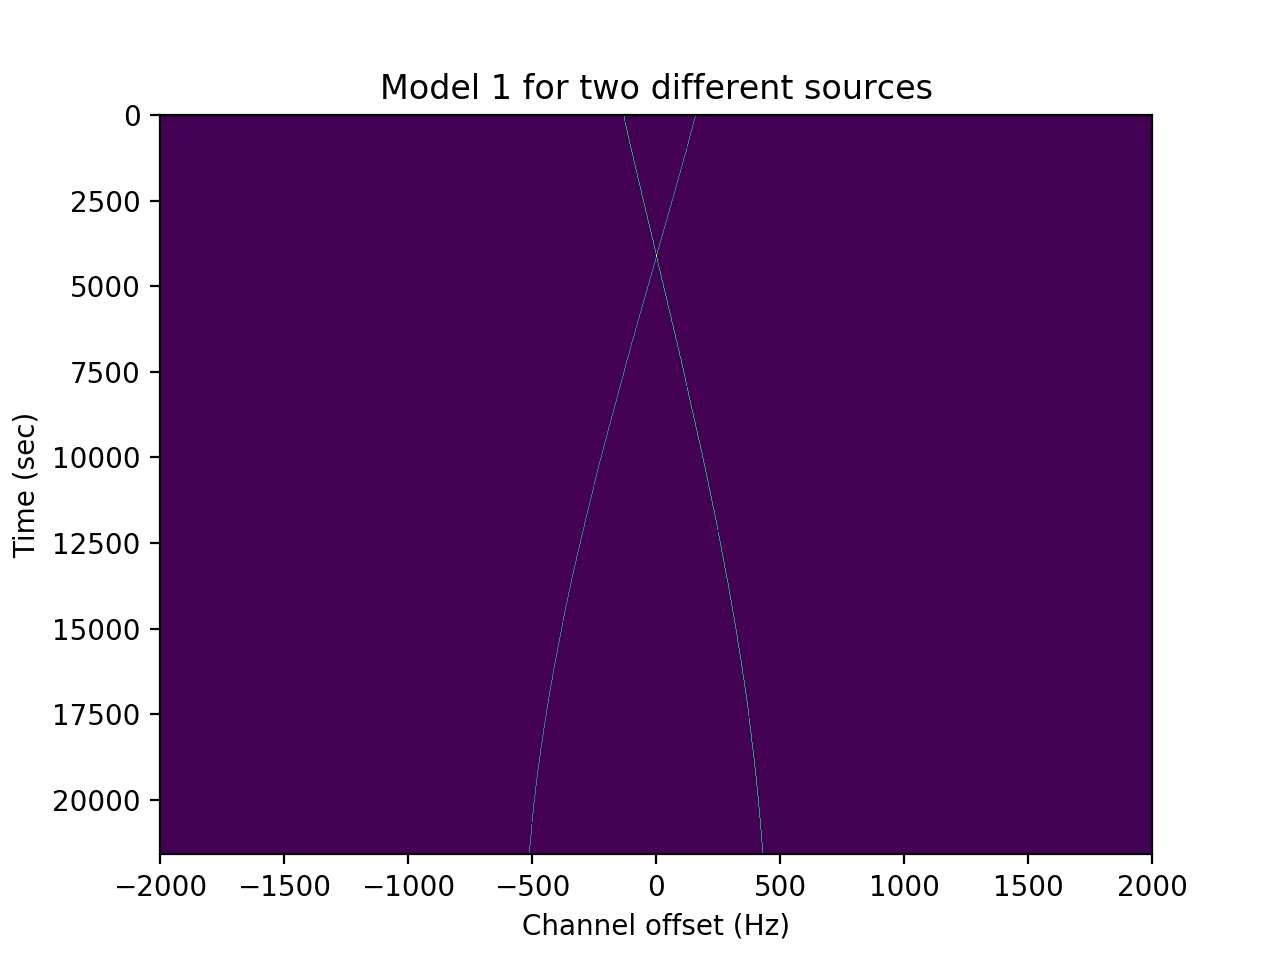

Text(0.5, 1.0, 'Model 1 for two different sources')

In [33]:
%matplotlib notebook
waterfall(f, time, Tsys, flo, fhi, bw, minsmear, obs_gcrs_Ddot, obs_gcrs_Ddot2, 5)
plt.title("Model 1 for two different sources")

And then the waterfall plot for model 2 of both sources:

<Waterfall setup>
	Nch: 4000, Ntimes: 1001
	flo: -2000.00 Hz, fhi: 2000.00 Hz, int_time: 21.6 s
<Adding 0>


<IPython.core.display.Javascript object>


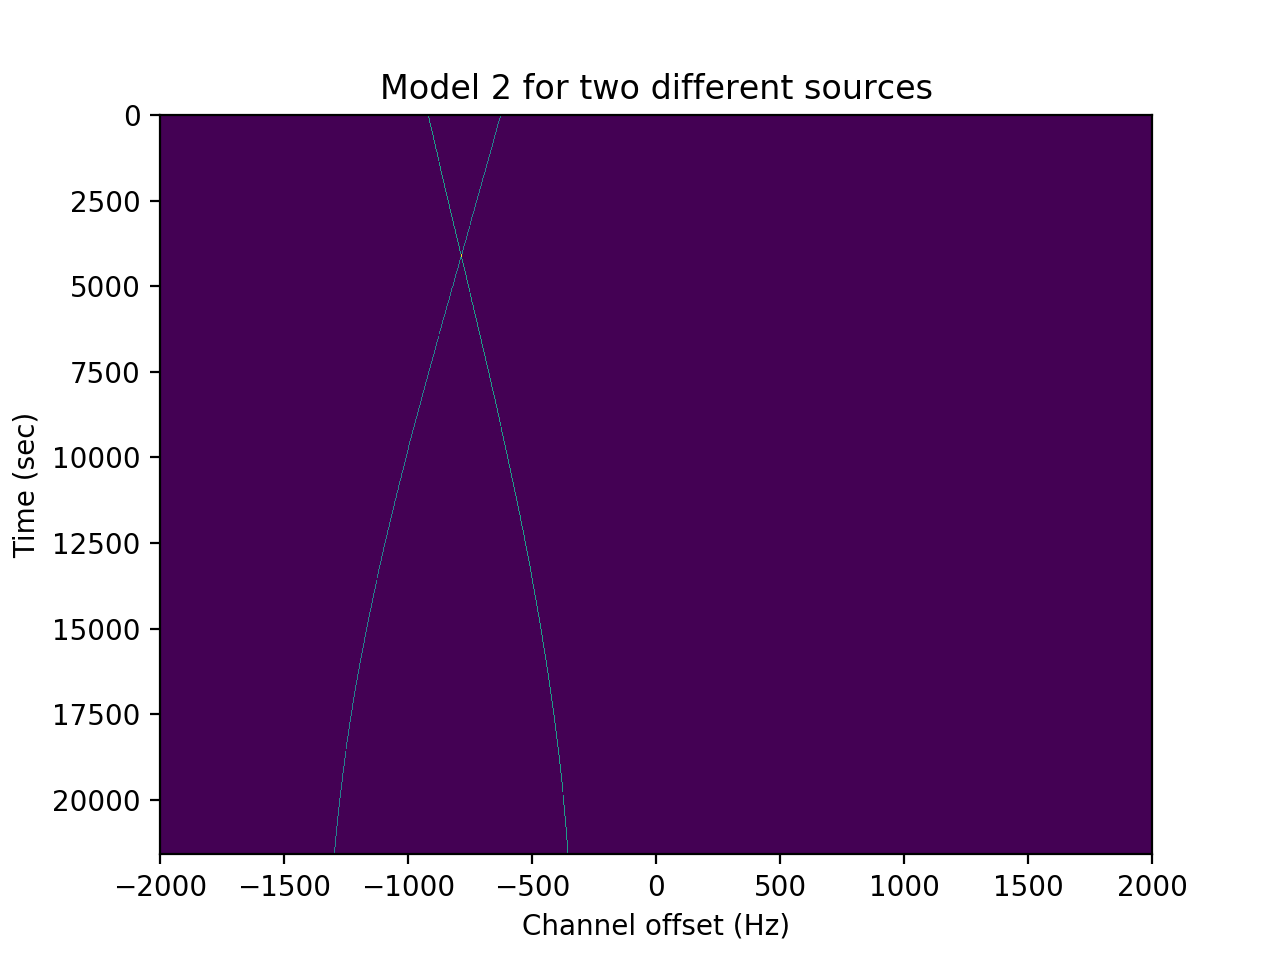

Text(0.5, 1.0, 'Model 2 for two different sources')

In [34]:
%matplotlib notebook
waterfall(f, time, Tsys, flo, fhi, bw, minsmear, obs_gcrs_Ddot - gcd.Ddot, obs_gcrs_Ddot2 - gcd.Ddot, 5)
plt.title('Model 2 for two different sources')

Another plot that's helpful to make is one that comapres the velocity of the frequency change of the original and second signal sources for both corrections that we've been dealing with. Again, the differences between the two models for each source is easier to see while zoomed in.

In [35]:
drift_obs2 = ((f * (obs_gcrs_Ddotdot2.value - gcd.Ddotdot.value[0:-1])) / c0).value
drift_gcrs2 = ((f * (obs_gcrs_Ddotdot2)) / c0).value

<IPython.core.display.Javascript object>


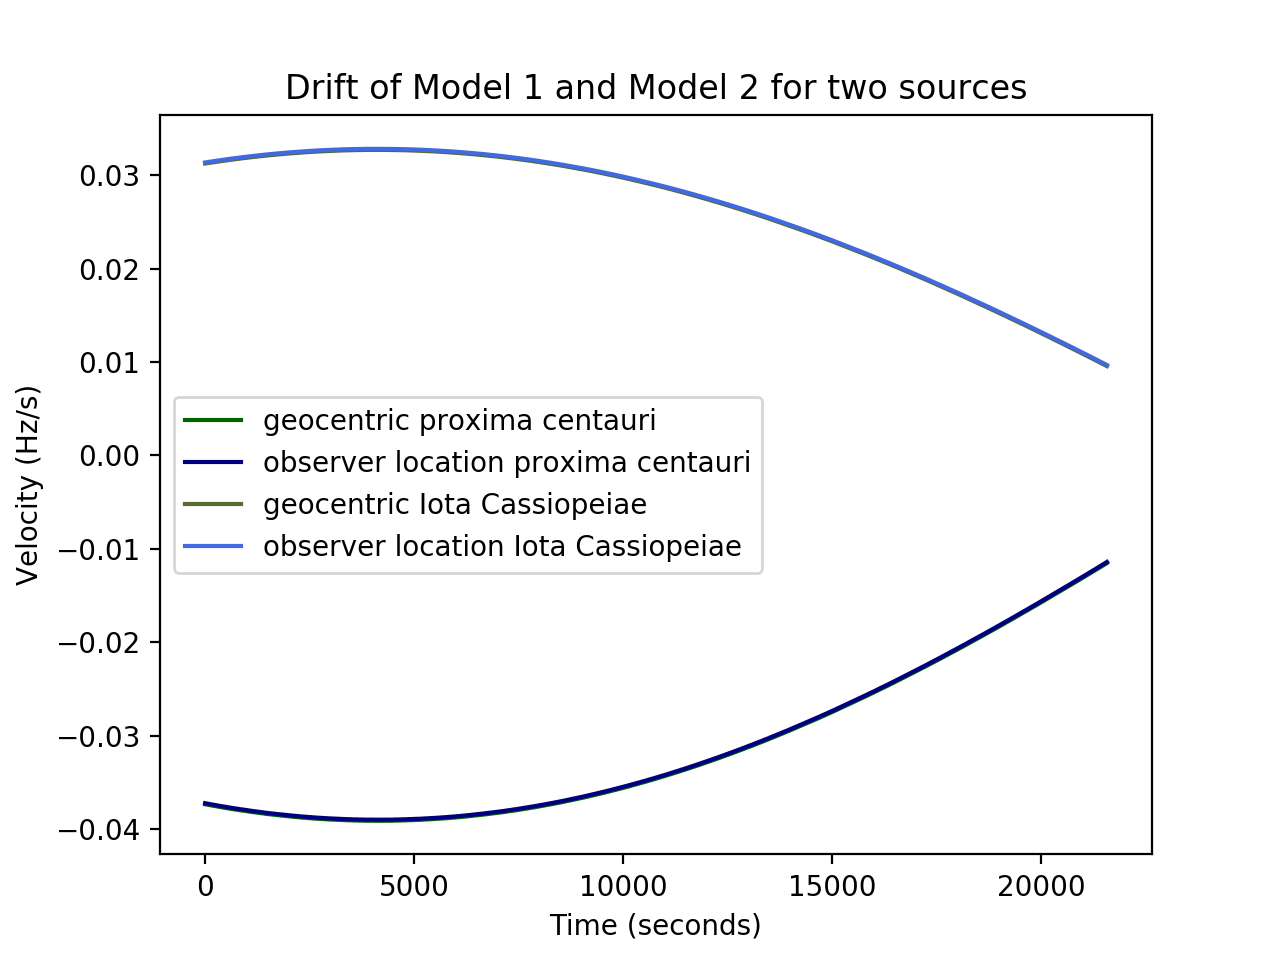

Text(0, 0.5, 'Velocity (Hz/s)')

In [36]:
%matplotlib notebook
plt.figure()
plt.plot(sec[0:-1], drift_gcrs, color = 'darkgreen', label = 'geocentric ' + soi)
plt.plot(sec[0:-1], drift_obs, color = 'navy', label = 'observer location ' + soi)
plt.plot(sec[0:-1], drift_gcrs2, color = 'darkolivegreen', label = 'geocentric ' + soi2)
plt.plot(sec[0:-1], drift_obs2, color = 'royalblue', label = 'observer location ' + soi2)
plt.legend()
plt.title("Drift of Model 1 and Model 2 for two sources")
plt.xlabel("Time (seconds)")
plt.ylabel("Velocity (Hz/s)")

### Compare the drifts from two different observer locations

The last thing we're going to look at is comparing the drift rates from the original signal source at two different observer locations on the Earth. All of the code below is the same as at the beginning, but just looking from a different observatory. Again, to maximize the difference in drift, the best thing is to pick an observatory on the opposite side of the Earth.

In [37]:
name2 = input("Input location code of observatory: ")
if name2 in EarthLocation.get_site_names():
    obs_loc2 = EarthLocation.of_site(name2)
else:
    print("That observatory is not in EarthLocation. Please input the location of the observatory manually!")
    lat2 = input("Latitude of the location of observation (in degrees): ")
    lon2 = input("Longitude of the location of observation (in degrees): ")
    height2 = input("Altitude of the location of observation (in meters): ")
    obs_loc2 = EarthLocation(lon = float(lon2) * u.deg, lat = float(lat2) * u.deg, height = float(height2) * u.m)

Input location code of observatory: CHARA


In [38]:
altaz2 = []
obs_az2 = []
obs_el2 = []

ptg2 = SkyCoord(ra=np.deg2rad(ra) * u.rad, dec=np.deg2rad(dec) * u.rad, unit = 'rad', frame='icrs')
for i in range(len(time)):
    altaz2.append(ptg2.gcrs.transform_to(AltAz(obstime = time.value[i], location = obs_loc2)))
    obs_az2.append(altaz2[i].az.value)
    obs_el2.append(altaz2[i].alt.value)

In [39]:
#Geocentric
obs_gcrs_r3, obs_gcrs_v3 = obs_loc2.get_gcrs_posvel(time)

obs_gcrs_D3 = (sig_x/d) * obs_gcrs_r3.x + (sig_y/d) * obs_gcrs_r3.y + (sig_z/d) * obs_gcrs_r3.z
obs_gcrs_Ddot3 = (sig_x/d) * obs_gcrs_v3.x + (sig_y/d) * obs_gcrs_v3.y + (sig_z/d) * obs_gcrs_v3.z
obs_gcrs_Ddotdot3 = diff(obs_gcrs_Ddot3) / diff(sec)

In [40]:
#Barycentric
bary.at(time)

obs_icrs_v_x3 = bary.xdot + obs_gcrs_v3.x
obs_icrs_v_y3 = bary.ydot + obs_gcrs_v3.y
obs_icrs_v_z3 = bary.zdot + obs_gcrs_v3.z

obs_icrs_Ddot3 = (sig_x/d) * obs_icrs_v_x3 + (sig_y/d) * obs_icrs_v_y3 + (sig_z/d) * obs_icrs_v_z3
obs_icrs_Ddotdot3 = diff(obs_icrs_Ddot3) / diff(sec)

We're going to plot the zoomed in version of the ecliptic plot from above to show the difference between the rotation of the Earth at the two different observer locations.

To get the new file, create an ephemeris (using JPL Horizons) looking at Solar System Barycenter (0) from the second location for the whole year (for example, if the signal was observed in 2021, Start = 2021-01-01 00:00:00 & Stop = 2022-01-01 00:00:00) (Step = 4 hours) and copy into a new .dat file.

In [41]:
obs2_file = input("File name (including .dat) for looking at SSB from the second telescope: ")
obs2 = horizons.Horizons(obs2_file)

File name (including .dat) for looking at SSB from the second telescope: chara_ssb.dat
Target body name: Solar System Barycenter (0)     {source: DE441}
Observers location: (user defined site below)
Start time      : A.D. 2019-Apr-29 00:00:00.0000 UT
Stop  time      : A.D. 2019-Apr-29 23:59:00.0000 UT
Step-size       : 15 minutes


<IPython.core.display.Javascript object>


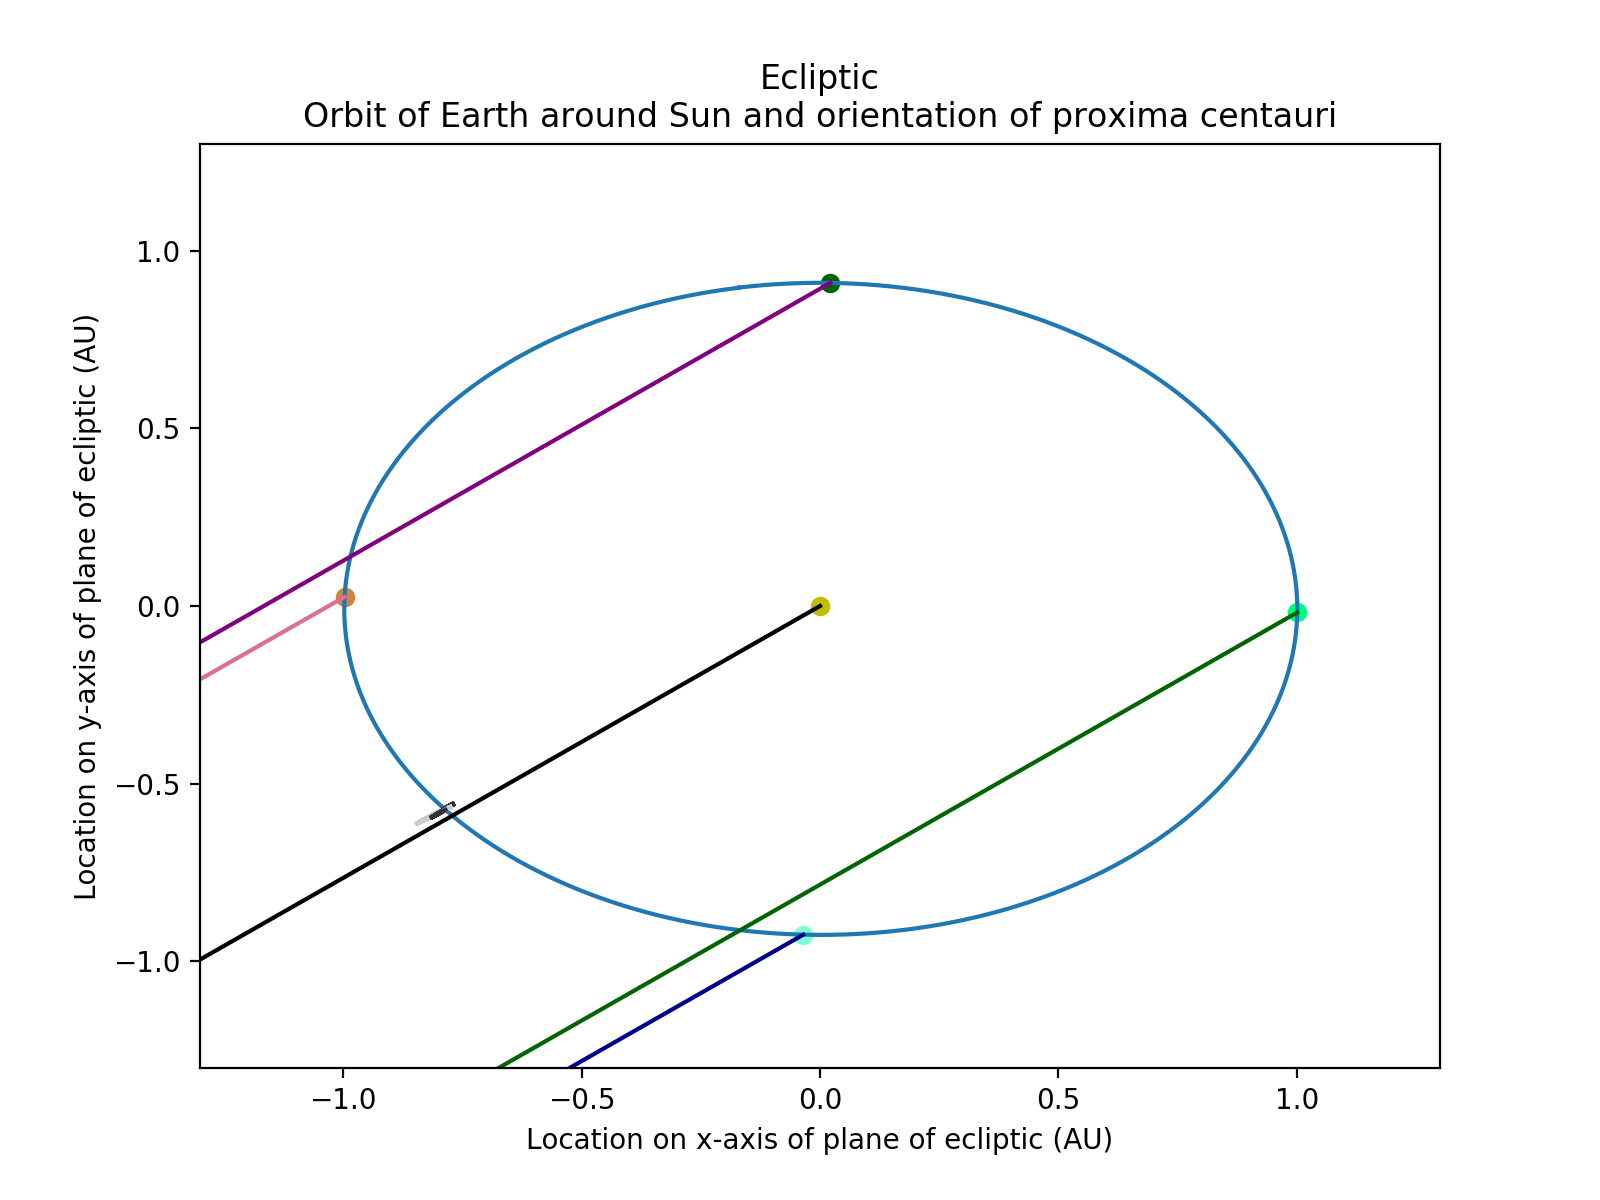

Text(0.5, 0, 'Location on x-axis of plane of ecliptic (AU)')

In [42]:
%matplotlib notebook
plt.figure(figsize = (8, 6))
obs1.at(time)
obs2.at(time)

plt.scatter(gc.x[468]/gc.au, gc.y[468]/gc.au, color = 'peru', label = 'Equinox in March')
plt.scatter(gc.x[1020]/gc.au, gc.y[1020]/gc.au, color = 'aquamarine', label = 'Solstice in June')
plt.scatter(gc.x[1584]/gc.au, gc.y[1584]/gc.au, color = 'springgreen', label = 'Equinox in September')#\n(Autumnal in Northern\nHemisphere and Vernal in Southern Hemisphere)')
plt.scatter(gc.x[2124]/gc.au, gc.y[2124]/gc.au, color = 'darkgreen', label = 'Solstice in December')

plt.plot(gc.x/gc.au, gc.y/gc.au)
plt.plot(0, 0, 'yo', label = 'Sun')
plt.plot([0, sig_x.value], [0, sig_y.value], 'k')

plt.plot([gc.x[2124]/gc.au, sig_x.value], [gc.y[2124]/gc.au, sig_y.value], color = 'purple')
plt.plot([(gc.x/gc.au)[468], sig_x.value], [gc.y[468]/gc.au, sig_y.value], color = 'palevioletred')
plt.plot([(gc.x/gc.au)[1020], sig_x.value], [gc.y[1020]/gc.au, sig_y.value], color = 'darkblue')
plt.plot([(gc.x/gc.au)[1584], sig_x.value], [gc.y[1584]/gc.au, sig_y.value], color = 'darkgreen')

for i in range(0, len(obs1.x), 1):
    x = -(obs1.x[i]/au).value
    y = -(obs1.y[i]/au).value
    plt.plot([x, x - obs1.xdot[i].value/5000], [y, y - obs1.ydot[i].value/5000], '0.8')
    x2 = -(obs2.x[i]/au).value
    y2 = -(obs2.y[i]/au).value
    plt.plot([x, x - obs2.xdot[i].value/5000], [y, y - obs2.ydot[i].value/5000], '0.2')
    
plt.xlim(-1.3, 1.3)
#plt.legend(loc = 'upper left')
plt.ylim(-1.3, 1.3)
plt.title("Ecliptic\nOrbit of Earth around Sun and orientation of " + soi)
plt.ylabel("Location on y-axis of plane of ecliptic (AU)")
plt.xlabel("Location on x-axis of plane of ecliptic (AU)")

In the plot above, the grey lines represent the rotation of the Earth at the time of observation for the first location and the black lines represent the rotation of the Earth at the time of observation for the second location. If the observer locations are on opposite sides of the Earth, you can see that the curves of the grey lines and the curves of the black lines are opposite. This is because while one side of the Earth is moving toward the Sun, the other side is moving away.

Since there is only one signal, we can now move on to the waterfall plots. Below are waterfall plots that compare the drift of the signal star from the two different places on the Earth for both models. The signal that has more yellow in it is the signal observed from the second observer location.

<Waterfall setup>
	Nch: 4000, Ntimes: 1001
	flo: -2000.00 Hz, fhi: 2000.00 Hz, int_time: 21.6 s
<Adding 0>


<IPython.core.display.Javascript object>


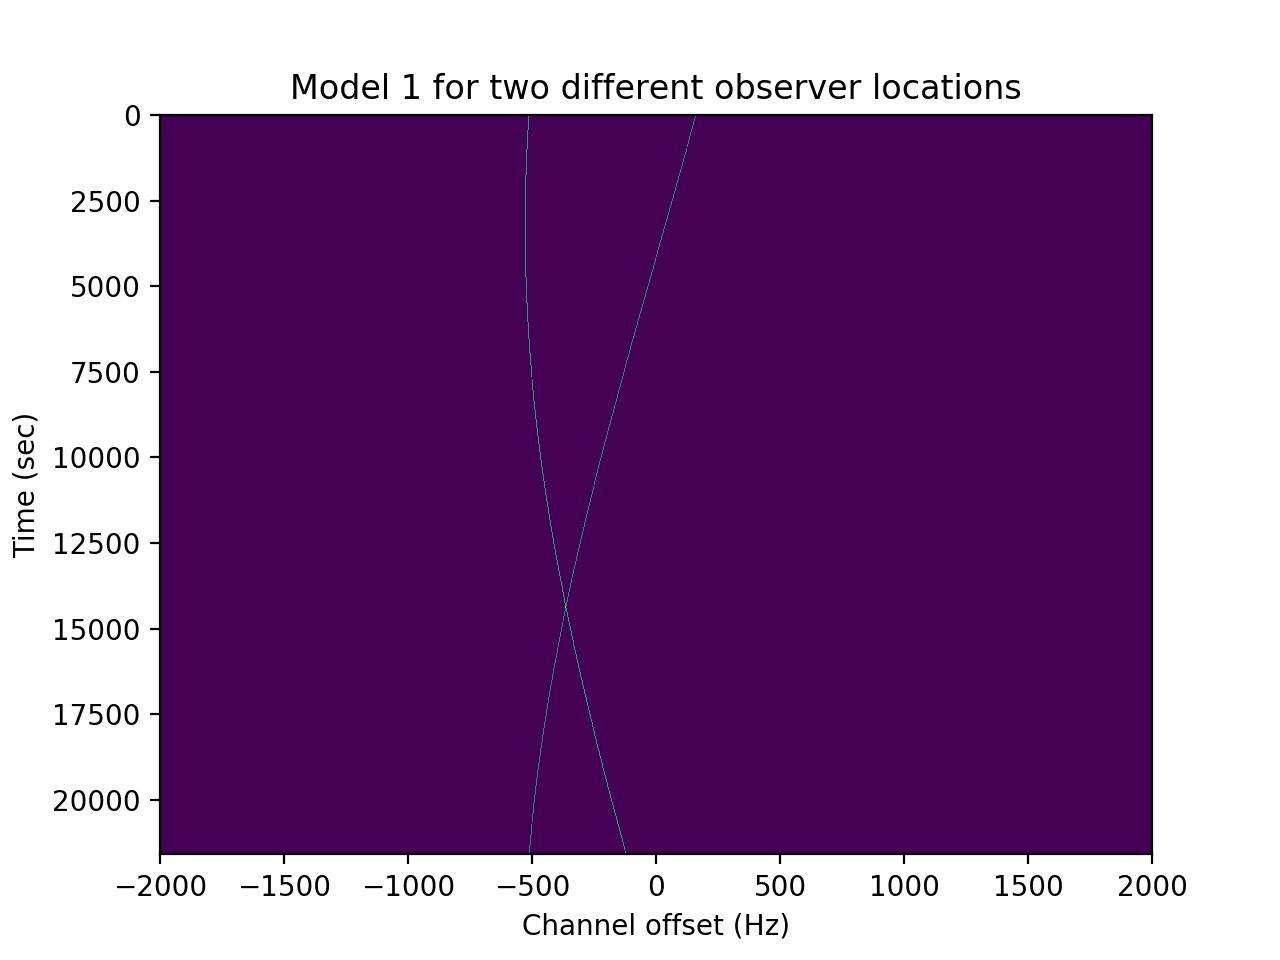

Text(0.5, 1.0, 'Model 1 for two different observer locations')

In [43]:
%matplotlib notebook
waterfall(f, time, Tsys, flo, fhi, bw, minsmear, obs_gcrs_Ddot, obs_gcrs_Ddot3, 5)
plt.title("Model 1 for two different observer locations")

<Waterfall setup>
	Nch: 4000, Ntimes: 1001
	flo: -2000.00 Hz, fhi: 2000.00 Hz, int_time: 21.6 s
<Adding 0>


<IPython.core.display.Javascript object>


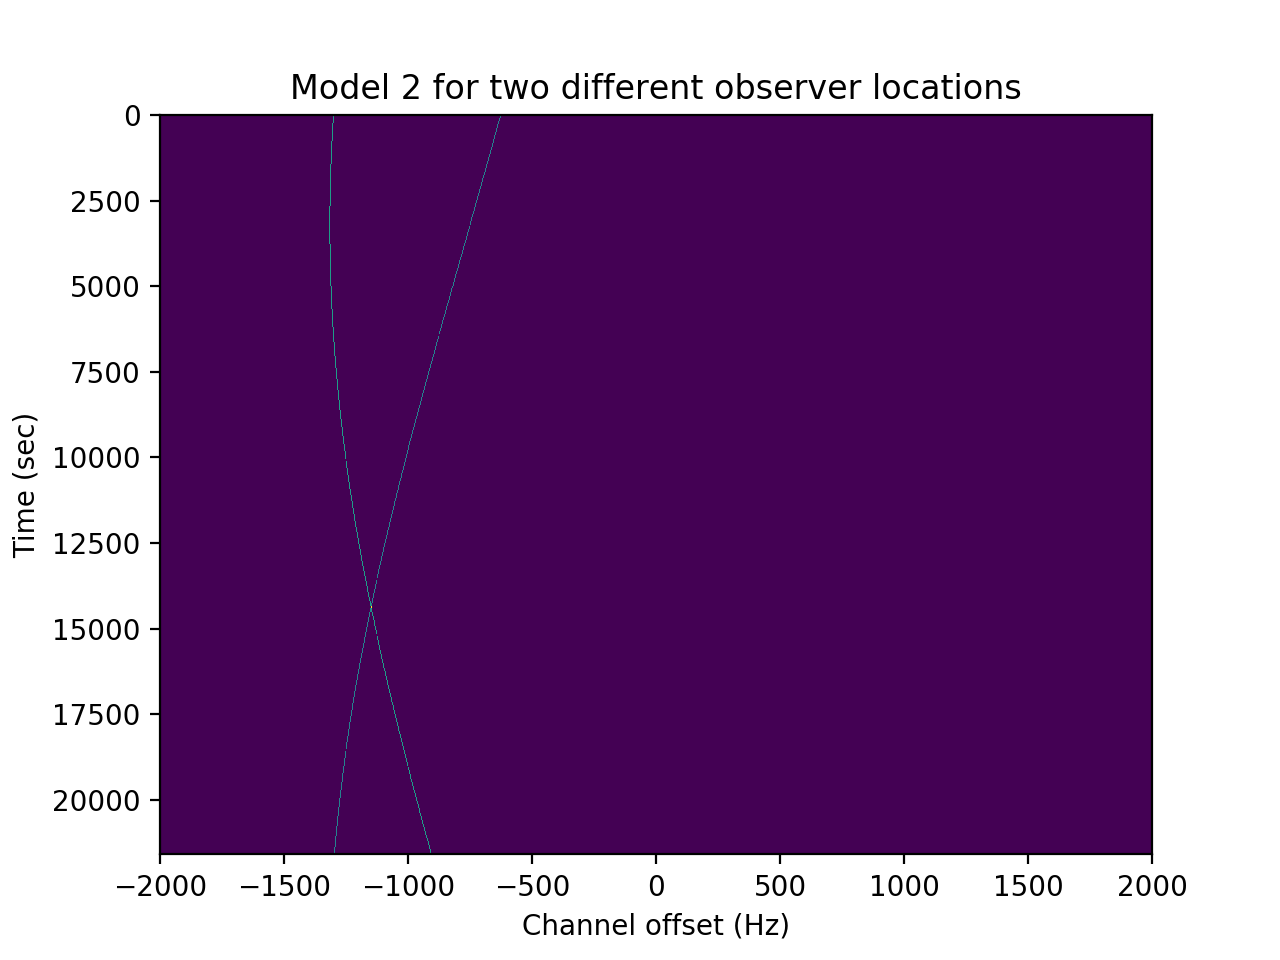

Text(0.5, 1.0, 'Model 2 for two different observer locations')

In [44]:
%matplotlib notebook
waterfall(f, time, Tsys, flo, fhi, bw, minsmear, obs_gcrs_Ddot - gcd.Ddot, obs_gcrs_Ddot3 - gcd.Ddot, 5)
plt.title("Model 2 for two different observer locations")

A final helpful plot is to compare the change in velocity of the frequency from the two different observer locations for the two different models. 

In [45]:
drift_obs3 = ((f * (obs_gcrs_Ddotdot3.value - gcd.Ddotdot.value[0:-1])) / c0).value
drift_gcrs3 = ((f * (obs_gcrs_Ddotdot3)) / c0).value

<IPython.core.display.Javascript object>


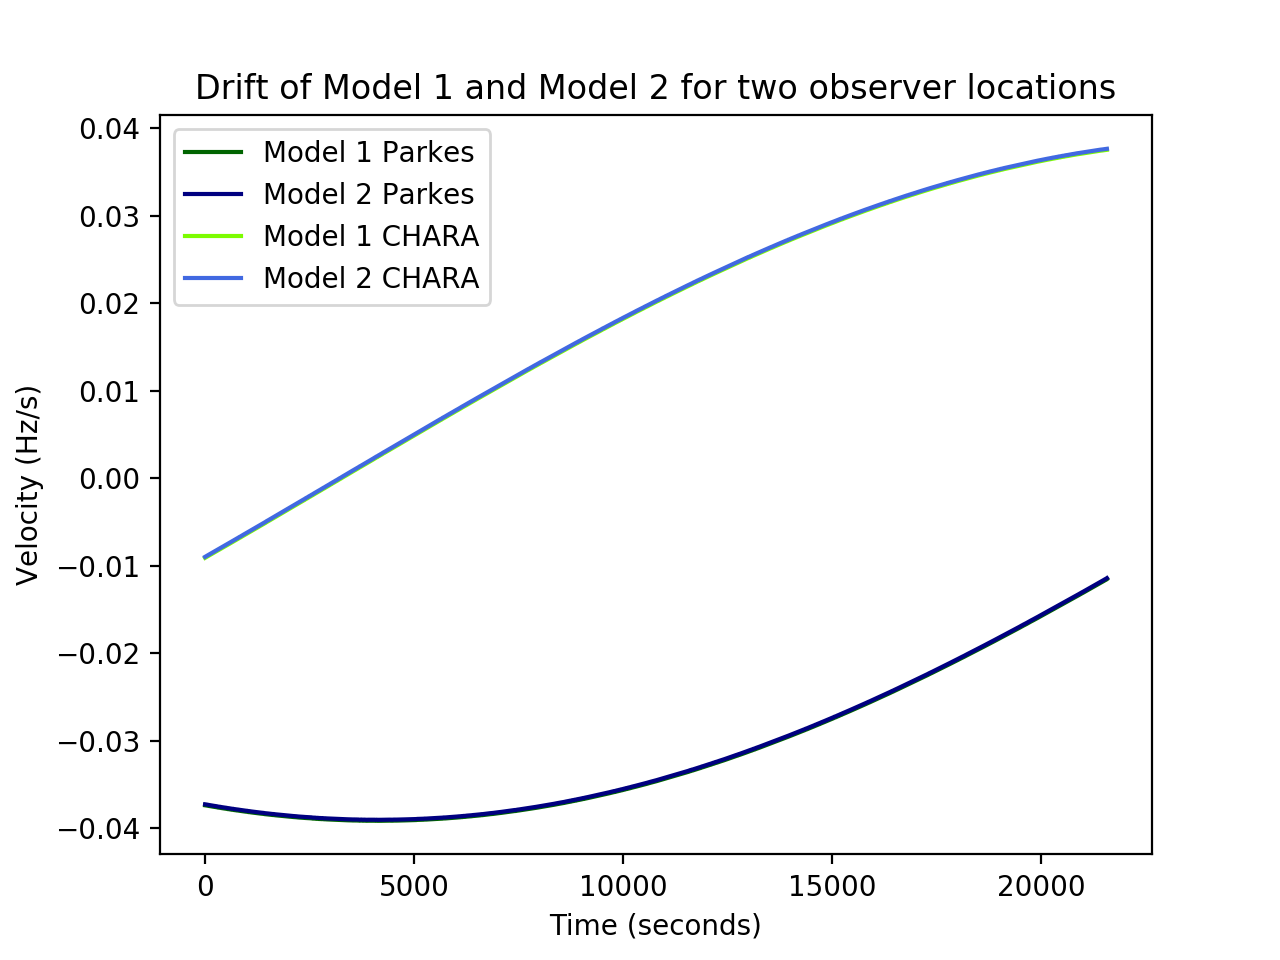

Text(0, 0.5, 'Velocity (Hz/s)')

In [46]:
%matplotlib notebook
plt.figure()
plt.plot(sec[0:-1], drift_gcrs, color = 'darkgreen', label = 'Model 1 ' + name)
plt.plot(sec[0:-1], drift_obs, color = 'navy', label = 'Model 2 ' + name)
plt.plot(sec[0:-1], drift_gcrs3, color = 'lawngreen', label = 'Model 1 ' + name2)
plt.plot(sec[0:-1], drift_obs3, color = 'royalblue', label = 'Model 2 ' + name2)
plt.legend()
plt.title("Drift of Model 1 and Model 2 for two observer locations")
plt.xlabel("Time (seconds)")
plt.ylabel("Velocity (Hz/s)")

*******
## Note on coordinate systems

### International Celestial Reference System (ICRS)
- The official celestial reference system of the IAU. The overall origin of the system is located at the barycenter of our solar system, which is located within the radius of the Sun; right ascension is set so that 3C 273B, which is a quasar within the constellation Virgo, is at 12h 29m 6.6997s at J2000.0 (aka the Vernal Equinox); the origin of declination is at the mean equator of J2000.0. This system is based on the positions of quasars and other extragalactic radio sources, and essentially sets the standard for the Barycentric Celestial Reference System (BCRS). Right ascension is given in units of hour angles and declination is given in units of degrees.

### Geocentric Celestial Reference System (GCRS)
- This reference system is primarily used for objects which orbit around the Earth and are therefore affected by the Earth’s gravitational force. As such, the origin is located at the center of the Earth (or the geocenter); the origin of right ascension is located at the Vernal Equinox, where the path of the Sun meets the celestial equator in May; the origin of declination is at the celestial equator. Right ascension is measured in units of hour angles and declination is measured in units of degrees. It is intended to be stationary with respect to the BCRS.

### Horizontal Coordinate System
- This system is dependent on the position of the observer and uses azimuth and altitude instead of right ascension and declination. Azimuth is given in units of hour angles clockwise from North, and altitude is given in units of degrees upward from the horizon. The Horizontal Coordinate System is useful for identifying objects in the sky at a given position, but does not provide a standardized way to find an object at any location.

#### The difference between Reference Systems and Reference Frames:
- **Reference Systems** are idealized, theoretical ways to find the location of objects. These may include a model or a set of standards on how to construct a reference frame.
- **Reference Frames** are the practical realizations of reference systems using equatorial coordinates (ra, dec). This is where you go in and actually use the origins to find the locations of objects with respect to stars, quasars, etc.

For equatorial systems, the reference systems are realized by implementing the origins of right ascension and declination to be the origins of longitude and latitude for the body at the origin. For GCRS, this is based on the vernal equinox and the celestial equator (which is a celestial projection of Earth’s equator). For BCRS, this is again the vernal equinox and the mean equator of J2000.0.


#### What objects use which systems?
- Satellites - GCRS in xyz coordinates in units of meters
- Telescopes - Horizontal Coordinate system using altitude (or elevation) and azimuth (transforms from ra and dec)
- Deep space Probes - BCRS or ICRS in equatorial coordinates
- Stars and other astronomical objects - BCRS or ICRS in equatorial coordinates

To find more information on coordinate systems, go to the IERS (International Earth Rotation and Reference Systems Services) <a href = "https://www.iers.org/IERS/EN/Service/Glossary/glossary_node.html">website</a>.

*******
## The role of astropy in analyzing drift

### Time

Time is an object in astropy.time that is used to transform a time given (as a string or as datetime.datetime) into another format. To do this, it makes a Time object that you can then use to transform time scales.

How to access Time formats:

In [47]:
Time.FORMATS

OrderedDict([('jd', astropy.time.formats.TimeJD),
             ('mjd', astropy.time.formats.TimeMJD),
             ('decimalyear', astropy.time.formats.TimeDecimalYear),
             ('unix', astropy.time.formats.TimeUnix),
             ('cxcsec', astropy.time.formats.TimeCxcSec),
             ('gps', astropy.time.formats.TimeGPS),
             ('plot_date', astropy.time.formats.TimePlotDate),
             ('stardate', astropy.time.formats.TimeStardate),
             ('datetime', astropy.time.formats.TimeDatetime),
             ('ymdhms', astropy.time.formats.TimeYMDHMS),
             ('iso', astropy.time.formats.TimeISO),
             ('isot', astropy.time.formats.TimeISOT),
             ('yday', astropy.time.formats.TimeYearDayTime),
             ('datetime64', astropy.time.formats.TimeDatetime64),
             ('fits', astropy.time.formats.TimeFITS),
             ('byear', astropy.time.formats.TimeBesselianEpoch),
             ('jyear', astropy.time.formats.TimeJulianEpoch),
       

An explanation of the Time formats:
- <i> jd </i> = time as a Julian Date (number of days from the beginning of the Julian period [January 1st, 4712 BC at 12:00pm UTC])
- <i> mjd </i> = time as a Modified Julian Date (number of days from November 17th, 1858 at midnight UTC)
- <i> decimalyear </i> = time as a decimal year (integer is the year with decimal being how far into the year the date and time are as a percentage of the total time in a year)
- <i> unix </i> = time in UTC given in seconds from January 1st, 1970 at midnight UTC
- <i> cxcsec </i> = time in seconds given at the Chandra X-Ray Center from January 1st, 1998 at midnight (excludes leap seconds)
- <i> gps </i> = time in seconds from January 6th, 1980 at midnight UTC (includes leap seconds)
- <i> plot_date </i> = time in number of days (plus 1) from January 1st, 1 AD at midnight UTC. Can be used in the matplotlib plot_date function
- <i> stardate </i> = time as a stardate (from Star Trek) with stardate 0.0 on July 5th, 2318 at 12:00:00 UTC
- <i> datetime </i> = transforms time into a datetime object (the same as datetime.datetime)
- <i> ymdhms </i> = represents the time in terms of year, month, date, hour, minute, second
- <i> iso </i> = time in format of YYYY-MM-DD HH:MM:SS.sss
- <i> isot </i> = time in format of YYYY-MM-DDTHH:MM:SS.sss (same as iso, but a T instead of a space between DD and HH)
- <i> yday </i> = time in format of YYYY:DOY:HH:MM:SS.sss (DOY is the day of the year from 001 to 365 [or 366 on a leap year])
- <i> datetime64 </i> = time in format of YYYY-MM-DDTHH:MM:SS.sssssssss
- <i> fits </i> = time in format of (±Y)YYYY-MM-DDTHH:MM:SS.sss (same as isot, but with the ability to have a five digit long year [more relevant for negative years (BC)])
- <i> byear </i> = time given as a float relative to Besselian Epoch 
- <i> jyear </i> = time given as a float relative to Julian Epoch 
- <i> byear_str </i> = byear given as a string with a B at the front
- <i> jyear_str </i> = jyear given as a string with a J at the front

With time as a string:

In [48]:
time_ex = '2000-01-01 00:00:00'
time_ex_T = Time(time_ex, scale = 'utc')
print('Time as a Julian Date: ', time_ex_T.jd)
print('Time as a Modified Julian Date: ', time_ex_T.mjd)
print('Time as a Decimal Year: ', time_ex_T.decimalyear)
print('Time in seconds from January 1st, 1970 at midnight UTC: ', time_ex_T.unix)
print('Time in seconds from January 1st, 1998 at midnight: ', time_ex_T.cxcsec)
print('Time in seconds from January 6th, 1980 at midnight UTC: ', time_ex_T.gps)
print('Time in number of days (plus 1) from January 1st, 1 AD at midnight UTC: ', time_ex_T.plot_date)
print('Time in stardate: ', time_ex_T.stardate)
print('Time as a datetime object: ', time_ex_T.datetime)
print('Time in terms of year, month, date, hour, minute, second: ', time_ex_T.ymdhms)
print('Time in format of YYYY-MM-DD HH:MM:SS.sss: ', time_ex_T.iso)
print('Time in format of YYYY-MM-DDYHH:MM:SS.sss: ', time_ex_T.isot)
print('Time in format of YYYY:DOY:HH:MM:SS.sss: ', time_ex_T.yday)
print('Time in datetime64: ', time_ex_T.datetime64)
print('Time in format of (±Y)YYYY-MM-DDTHH:MM:SS.sss: ', time_ex_T.fits)
print('Time given as a float relative to Besselian Epoch : ', time_ex_T.byear)
print('Time given as a float relative to Julian Epoch : ', time_ex_T.jyear)
print('Time as byear given as a string with a B at the front: ', time_ex_T.byear_str)
print('Time as jyear given as a string with a J at the front: ', time_ex_T.jyear_str)


Time as a Julian Date:  2451544.5
Time as a Modified Julian Date:  51544.0
Time as a Decimal Year:  2000.0
Time in seconds from January 1st, 1970 at midnight UTC:  946684800.0
Time in seconds from January 1st, 1998 at midnight:  63072064.184
Time in seconds from January 6th, 1980 at midnight UTC:  630720013.0
Time in number of days (plus 1) from January 1st, 1 AD at midnight UTC:  730120.0
Time in stardate:  -292463.9300841168
Time as a datetime object:  2000-01-01 00:00:00
Time in terms of year, month, date, hour, minute, second:  (2000, 1, 1, 0, 0, 0.)
Time in format of YYYY-MM-DD HH:MM:SS.sss:  2000-01-01 00:00:00.000
Time in format of YYYY-MM-DDYHH:MM:SS.sss:  2000-01-01T00:00:00.000
Time in format of YYYY:DOY:HH:MM:SS.sss:  2000:001:00:00:00.000
Time in datetime64:  2000-01-01T00:00:00.000000000
Time in format of (±Y)YYYY-MM-DDTHH:MM:SS.sss:  2000-01-01T00:00:00.000
Time given as a float relative to Besselian Epoch :  1999.9999085590325
Time given as a float relative to Julian Epo

And as a datetime object:

In [49]:
time_ex2 = datetime(2000, 1, 1, 0, 0, 0)
time_ex_T = Time(time_ex, scale = 'utc')
print('Time as a Julian Date: ', time_ex_T.jd)
print('Time as a Modified Julian Date: ', time_ex_T.mjd)
print('Time as a Decimal Year: ', time_ex_T.decimalyear)
print('Time in seconds from January 1st, 1970 at midnight UTC: ', time_ex_T.unix)
print('Time in seconds from January 1st, 1998 at midnight: ', time_ex_T.cxcsec)
print('Time in seconds from January 6th, 1980 at midnight UTC: ', time_ex_T.gps)
print('Time in number of days (plus 1) from January 1st, 1 AD at midnight UTC: ', time_ex_T.plot_date)
print('Time in stardate: ', time_ex_T.stardate)
print('Time as a datetime object: ', time_ex_T.datetime)
print('Time in terms of year, month, date, hour, minute, second: ', time_ex_T.ymdhms)
print('Time in format of YYYY-MM-DD HH:MM:SS.sss: ', time_ex_T.iso)
print('Time in format of YYYY-MM-DDYHH:MM:SS.sss: ', time_ex_T.isot)
print('Time in format of YYYY:DOY:HH:MM:SS.sss: ', time_ex_T.yday)
print('Time in datetime64: ', time_ex_T.datetime64)
print('Time in format of (±Y)YYYY-MM-DDTHH:MM:SS.sss: ', time_ex_T.fits)
print('Time given as a float relative to Besselian Epoch : ', time_ex_T.byear)
print('Time given as a float relative to Julian Epoch : ', time_ex_T.jyear)
print('Time as byear given as a string with a B at the front: ', time_ex_T.byear_str)
print('Time as jyear given as a string with a J at the front: ', time_ex_T.jyear_str)

Time as a Julian Date:  2451544.5
Time as a Modified Julian Date:  51544.0
Time as a Decimal Year:  2000.0
Time in seconds from January 1st, 1970 at midnight UTC:  946684800.0
Time in seconds from January 1st, 1998 at midnight:  63072064.184
Time in seconds from January 6th, 1980 at midnight UTC:  630720013.0
Time in number of days (plus 1) from January 1st, 1 AD at midnight UTC:  730120.0
Time in stardate:  -292463.9300841168
Time as a datetime object:  2000-01-01 00:00:00
Time in terms of year, month, date, hour, minute, second:  (2000, 1, 1, 0, 0, 0.)
Time in format of YYYY-MM-DD HH:MM:SS.sss:  2000-01-01 00:00:00.000
Time in format of YYYY-MM-DDYHH:MM:SS.sss:  2000-01-01T00:00:00.000
Time in format of YYYY:DOY:HH:MM:SS.sss:  2000:001:00:00:00.000
Time in datetime64:  2000-01-01T00:00:00.000000000
Time in format of (±Y)YYYY-MM-DDTHH:MM:SS.sss:  2000-01-01T00:00:00.000
Time given as a float relative to Besselian Epoch :  1999.9999085590325
Time given as a float relative to Julian Epo

As you can see, you get the same values if you use a string or if you use datetime.datetime.

To find more information on astropy.time.Time, go to <a href = "https://docs.astropy.org/en/stable/time/#time-from-epoch-formats">the documentation</a>.

### Coordinates

When you receive an incoming signal, it is important to consider in what frame the incoming signal was given. If this frame is different than the one you want, it is easy to use astropy.coordinates to change it. 

To find more information on astropy.coordinates, go to <a href = "https://docs.astropy.org/en/stable/coordinates/index.html">the documentation</a>.

#### SkyCoord

Assume we're looking at a signal from Betelgeuse:

In [50]:
betelgeuse = SkyCoord.from_name("betelgeuse")

In [51]:
print(betelgeuse)

<SkyCoord (ICRS): (ra, dec) in deg
    (88.79293899, 7.407064)>


The default frame of SkyCoord is the International Celestial Reference Frame. It is possible to either specify a different frame at the outset or to transform to the desired frame of reference.

In [52]:
# specify at outset
betelgeuse_gcrs = SkyCoord.from_name('betelgeuse', frame = 'gcrs')
print(betelgeuse_gcrs)

# transform to gcrs
betelgeuse.gcrs

<SkyCoord (GCRS: obstime=J2000.000, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec) in deg
    (88.79865781, 7.4067902)>


<SkyCoord (GCRS: obstime=J2000.000, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec) in deg
    (88.79865781, 7.4067902)>

You can see that these two methods give you the same values of right ascension and declination.

Something else you can change is the coordinate system of the point on the sky. To transform to cartesian coordinates in the International Celestial Reference Frame:

In [53]:
betelgeuse.cartesian

<CartesianRepresentation (x, y, z) [dimensionless]
    (0.02088984, 0.99143522, 0.12891786)>

You can also get the coordinates of an object at any point on the sky by manually inputting the longitude (ra) and latitude (dec).

In [54]:
#Below, I just chose random numbers for ra and dec as an example
lonlat = SkyCoord(34.233, -30.452, unit = u.deg, frame = 'icrs')
print(lonlat)

<SkyCoord (ICRS): (ra, dec) in deg
    (34.233, -30.452)>


You can then also transform the frame or coordinate system in a similar way as above:

In [55]:
print(lonlat.gcrs, '\n')
print(lonlat.cartesian)

<SkyCoord (GCRS: obstime=J2000.000, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec) in deg
    (34.23579407, -30.4550181)> 

(0.71270896, 0.48495682, -0.50681635) 


The different frames offered are:

- icrs: International Celestial Reference System- Origin at the barycenter of the solar system, ra = 0 at Vernal equinox, dec = 0 at the equator of J2000.0
- gcrs: Geocentric Celestial Reference System- Origin at the center of the Earth, ra = 0 at Vernal equinox, dec = 0 at celestial equator
- fk4: catalog of 1,535 stars with equinoxes from 1950.0, published in 1963 as an update to fk3 
- fk5: update of fk4 with new positions for the 1,535 stars, published in 1988
- galactic: galactic latitude (l) given as an angle offset from the direction of the Milky Way as seen from the Sun and galactic longitude (b) given as an angle up from (or below) the galactic plane
- itrs: International Terrestrial Reference System- Origin at the center of the Earth, same as GCRS, but it rotates with the Earth
- hcrs (cannot directly transform from hcrs to icrs): Heliocentric Celestial Reference System, axes the same as the ICRS

There are more, but these are the most common.

Coordinate transformations are important for use in drift rate analysis because you want to make sure that the corrections you're considering are in the frame you want. For radio astronomy, the Barycentric Celestial Reference System (and, by extension, the ICRS) are the most important frame. However, for certain corrections- such as drift due to: the rotation of the Earth around its axis, RFI from Earth-bound sources, and RFI from satellites- you may want to consider the GCRS.

In [56]:
print(betelgeuse.icrs)
print(betelgeuse.gcrs)
print(betelgeuse.fk4)
print(betelgeuse.fk5)
print(betelgeuse.galactic)
print(betelgeuse.itrs)

<SkyCoord (ICRS): (ra, dec) in deg
    (88.79293899, 7.407064)>
<SkyCoord (GCRS: obstime=J2000.000, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec) in deg
    (88.79865781, 7.4067902)>
<SkyCoord (FK4: equinox=B1950.000, obstime=B1950.000): (ra, dec) in deg
    (88.11620818, 7.39954494)>
<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (88.79294569, 7.40705853)>
<SkyCoord (Galactic): (l, b) in deg
    (199.78723618, -8.95860328)>
<SkyCoord (ITRS: obstime=J2000.000): (x, y, z) [dimensionless]
    (-0.97211074, 0.19593179, 0.12888536)>


You can also change the units in which the right ascension and declination are represented:

In [57]:
ra_deg = betelgeuse.ra.degree
ra_hms = betelgeuse.ra.hms

print("Regularly, the right ascension of sirius is represented as", betelgeuse.ra)
print("But you can transform it in to degrees:", ra_deg * u.degree, ", or hms:", ra_hms)

Regularly, the right ascension of sirius is represented as 88d47m34.5804s
But you can transform it in to degrees: 88.79293899 deg , or hms: hms_tuple(h=5.0, m=55.0, s=10.305357600001628)


To find more information on astropy.coordinates.SkyCoord, go to <a href = "https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html">the documentation</a>.

#### EarthLocation

EarthLocation is an object in astropy.coordinates that determines the location of a point on the Earth. This can be given in either x, y, and z coordinates or in terms of longitude and latitude.

For a location given in terms of latitude and longitude (here we'll look at UC Berkeley):

In [58]:
ucb = EarthLocation.from_geodetic(lon = 122.2585, lat = 37.8719)

From there, we can access longitude and latitude in units degrees of or x, y, and z in units of meters:

In [59]:
print("Longitude:", ucb.lon)
print("Latitude:", ucb.lat, '\n')

print("x coordinate:", ucb.x)
print("y coordinate:", ucb.y)
print("z coordinate:", ucb.z)

Longitude: 122d15m30.6s
Latitude: 37d52m18.84s 

x coordinate: -2690674.259345125 m
y coordinate: 4263059.080507876 m
z coordinate: 3894229.8663464105 m


To find more information on astropy.coordinates.EarthLocation, go to <a href = "https://docs.astropy.org/en/stable/api/astropy.coordinates.EarthLocation.html">the documentation</a>.

#### AltAz

One use for AltAz is to input the altitude and azimuth of the star at a specific time if you know it. This simply places the numbers into AltAz Coordinates:

In [60]:
(AltAz(alt = 20.03 * u.deg, az = -78.4 * u.deg))

<AltAz Coordinate (obstime=None, location=None, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (281.6, 20.03)>

For our purposes, the most important use for AltAz is to transform right ascension and declination into azimuth and altitude for a specific point on the Earth at a specific time, like we did above. To do this, all you need to input is the time and the location at which you observed the signal.

In [62]:
betelgeuse.icrs.transform_to(AltAz(obstime = time, location = ucb))

<SkyCoord (AltAz: obstime=[datetime.datetime(2019, 4, 29, 13, 0)
 datetime.datetime(2019, 4, 29, 13, 0, 21, 600000)
 datetime.datetime(2019, 4, 29, 13, 0, 43, 200000) ...
 datetime.datetime(2019, 4, 29, 18, 59, 16, 800000)
 datetime.datetime(2019, 4, 29, 18, 59, 38, 400000)
 datetime.datetime(2019, 4, 29, 19, 0)], location=(-2690674.25934512, 4263059.08050788, 3894229.86634641) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    [(273.07070099,   8.15273657), (273.12555392,   8.08160131),
     (273.18040209,   8.01046977), ..., (353.69853473, -44.52474085),
     (353.82359831, -44.53248286), (353.948697  , -44.54007024)]>

To find more information on astropy.coordinates.AltAz, go to <a href = "https://docs.astropy.org/en/stable/api/astropy.coordinates.AltAz.html">the documentation</a>.

### Units

When dealing with any equation, it is important to keep track of the units of each variable. An easy way to do this is using astropy.units. To apply units to any value, you just need to multiply the value by u.(unit you want). To show how this works, we're going to look at converting distance moved and time to velocity.

In [63]:
time_ex = 200 * u.s
m_ex = 400 * u.m
v_ex = m_ex/time_ex

In [64]:
print(time_ex)
print(m_ex)
print(v_ex)

200.0 s
400.0 m
2.0 m / s


As you can see above, the units are now a part of the value, so you can multiply or divide the values by each other and the units will also be multiplied or divided by each other.

You can also use astropy.units to perform unit conversions. All you need to do for this value.to(u.(unit you want)). To transform m_ex to units of kilometers:

In [65]:
m_ex.to(u.km)

<Quantity 0.4 km>

To find more information on astropy.units, go to <a href = "https://docs.astropy.org/en/stable/units/">the documentation</a>.

******
## References
The work done in this notebook is based on research done by Sheikh et al. and Smith et al., as well as code written by Dr. David DeBoer.

<i> Coordinate Systems </i><br>
* https://en.wikipedia.org/wiki/Right_ascension
* https://www.iers.org/IERS/EN/Science/ICRS/ICRS.html;jsessionid=8E3EF823D7B9B9900451562FB2FE6966.live2
* https://docs.astropy.org/en/stable/api/astropy.coordinates.ICRS.html#astropy.coordinates.ICRS
* https://en.wikipedia.org/wiki/International_Celestial_Reference_System#:~:text=The%20International%20Celestial%20Reference%20System,fixed%22%20with%20respect%20to%20space.
* https://en.wikipedia.org/wiki/Barycentric_and_geocentric_celestial_reference_systems
* https://arxiv.org/pdf/astro-ph/0602086.pdf 
* https://en.wikipedia.org/wiki/3C_273 
* http://articles.adsabs.harvard.edu//full/1995A%26A...303..604A/0000605.000.html
* https://gssc.esa.int/navipedia/index.php/Coordinate_Systems 
* https://en.wikipedia.org/wiki/Catalogues_of_Fundamental_Stars
* https://en.wikipedia.org/wiki/Galactic_coordinate_system
<br>

<i> Astropy </i><br>
* https://docs.astropy.org/en/stable/time/#time-from-epoch-formats
* https://docs.astropy.org/en/stable/coordinates/index.html
* https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html
* https://docs.astropy.org/en/stable/api/astropy.coordinates.EarthLocation.html
* https://docs.astropy.org/en/stable/api/astropy.coordinates.AltAz.html
* https://docs.astropy.org/en/stable/units/
* https://docs.astropy.org/en/stable/api/astropy.coordinates.HCRS.html


All files generated using JPL Horizons Web-Interface <br>
* https://ssd.jpl.nasa.gov/horizons.cgi#top

Stellarium was used as a reference for the location of the stars as well as the time in Julian and Modified Julian dates.

******
## Funding
<br>
Funding for this work was provided by the National Science Foundation and Breakthough Listen

*******
